In [54]:
# basics
import math
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime, timedelta
import json
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from scipy import stats

# plotting
import matplotlib.pyplot as plt

# shapefiles
import geopandas as gpd
import shapely


## Load rescaled Omicron case numbers

In [6]:
## epochs definitions (left/right inclusive)
epochs = {
    1: (dt.datetime(2021, 11, 1), dt.datetime(2021, 12, 25)),
    2: (dt.datetime(2021, 12, 26), dt.datetime(2022, 1, 15)),
    3: (dt.datetime(2022, 1, 16), dt.datetime(2022, 1, 31))
}

def bin_date(date_str, epochs):
    date = dt.datetime.strptime(date_str, '%Y-%m-%d')
    for k, v in epochs.items():
        if (date >= v[0] and date <= v[1]):
            return k
 

In [17]:
omicron_cases = pd.read_csv('master_final_re-scaled_cases_20210901_20220228.csv', sep=',').iloc[:,1:]
omicron_cases = omicron_cases[['LTLA_code', 'specimen_date', 'count_mean', 'samples', 'Total_number_of_cases']]
omicron_cases = omicron_cases.rename(columns={
    'LTLA_code': 'origin',
    'specimen_date': 'date'
})
omicron_cases['epoch'] = omicron_cases.date.apply(lambda x: bin_date(x, epochs))
omicron_cases = omicron_cases[(omicron_cases.date >= '2021-11-01') & (omicron_cases.date <= '2022-01-31')]


In [26]:
omicron_cases[omicron_cases.epoch == 1].count_mean.sum()
omicron_cases[(omicron_cases.epoch == 1) & 
              (omicron_cases.date < '2021-11-28') & 
              (omicron_cases.date > '2021-11-13')].count_mean.sum()


22223.05581841844

In [51]:
## aggregate from 2021-11-28 to 2022-01-31
omicron_cases_study = omicron_cases[(omicron_cases.date >= '2021-11-28') & \
                                    (omicron_cases.date <= '2022-01-31')].copy()
omicron_cases_study_agg = omicron_cases_study.groupby('origin').agg({'count_mean': 'sum'}).reset_index()
omicron_cases_study_agg


,origin,count_mean
0,E06000001,8600.559874
1,E06000002,13015.491082
2,E06000003,11984.899771
3,E06000004,18898.413039
4,E06000005,8705.815612
...,...,...
309,E09000029,19481.282951
310,E09000030,29035.634739
311,E09000031,24769.120314
312,E09000032,33328.888300


## Read in TL tip <-> LTLA

In [27]:
BA115_DTA_700_n713_tip_ltla = pd.read_csv('./BA.1.15_DTA_700_n713/tip_ltla_date_epo.tsv', sep='\t')
BA115_DTA_102_n2975_tip_ltla = pd.read_csv('./BA.1.15_DTA_102_n2975/tip_ltla_date_epo.tsv', sep='\t')
BA117_DTA_175_n11351_tip_ltla = pd.read_csv('./BA.1.17_DTA_175_n11351/tip_ltla_date_epo.tsv', sep='\t')
BA11_DTA_1467_n722_tip_ltla = pd.read_csv('./BA.1.1_DTA_1467_n722/tip_ltla_date_epo.tsv', sep='\t')
BA11_DTA_1254_n2249_tip_ltla = pd.read_csv('./BA.1.1_DTA_1254_n2249/tip_ltla_date_epo.tsv', sep='\t')
BA1_DTA_1944_n1406_tip_ltla = pd.read_csv('./BA.1_DTA_1944_n1406/tip_ltla_date_epo.tsv', sep='\t')
BA1_DTA_1800_n944_tip_ltla = pd.read_csv('./BA.1_DTA_1800_n944/tip_ltla_date_epo.tsv', sep='\t')
BA1_DTA_1207_n9727_tip_ltla = pd.read_csv('./BA.1_DTA_1207_n9727/tip_ltla_date_epo.tsv', sep='\t')


## Read in LTLA aggregations

In [28]:
BA115_DTA_700_n713_mergers_rev = pd.read_csv('./BA.1.15_DTA_700_n713/mergers_rev.tsv', sep='\t')
BA115_DTA_102_n2975_mergers_rev = pd.read_csv('./BA.1.15_DTA_102_n2975/mergers_rev.tsv', sep='\t')
BA117_DTA_175_n11351_mergers_rev = pd.read_csv('./BA.1.17_DTA_175_n11351/mergers_rev.tsv', sep='\t')
BA11_DTA_1467_n722_mergers_rev = pd.read_csv('./BA.1.1_DTA_1467_n722/mergers_rev.tsv', sep='\t')
BA11_DTA_1254_n2249_mergers_rev = pd.read_csv('./BA.1.1_DTA_1254_n2249/mergers_rev.tsv', sep='\t')
BA1_DTA_1944_n1406_mergers_rev = pd.read_csv('./BA.1_DTA_1944_n1406/mergers_rev.tsv', sep='\t')
BA1_DTA_1800_n944_mergers_rev = pd.read_csv('./BA.1_DTA_1800_n944/mergers_rev.tsv', sep='\t')
BA1_DTA_1207_n9727_mergers_rev = pd.read_csv('./BA.1_DTA_1207_n9727/mergers_rev.tsv', sep='\t')


## Read in TL estimated importation date

In [94]:
def dec2date(date_dec, get_str=False):
    year = math.floor(date_dec)
    year_start = dt.datetime(year, 1, 1)
    year_end = dt.datetime(year+1, 1, 1)
    
    year_dur = (year_end - year_start).days
    date_frac = date_dec % year
    date_days = round(year_dur*date_frac)
    
    date = year_start + dt.timedelta(days=date_days)
    
    if get_str:
        return dt.datetime.strftime(date, '%Y-%m-%d')
    else:
        return date
    

In [49]:
BA115_mcc_tls = pd.read_csv('../BA.1.15/mcc_tls/mcc_tls.tsv', sep='\t').iloc[:,2:]
BA115_mcc_tls = BA115_mcc_tls.loc[(BA115_mcc_tls.ntaxa > 0) & (BA115_mcc_tls.source == 'nonENG')]
BA115_mcc_tls['import_est'] = BA115_mcc_tls.apply(lambda row: (row.tmrca + row.ptmrca)/2, axis=1)
BA115_DTA_700_n713_import_est = BA115_mcc_tls[BA115_mcc_tls.ntaxa == 713].import_est.values[0]
BA115_DTA_102_n2975_import_est = BA115_mcc_tls[BA115_mcc_tls.ntaxa == 2975].import_est.values[0]

BA11_mcc_tls = pd.read_csv('../BA.1.1/mcc_tls/mcc_tls.tsv', sep='\t').iloc[:,2:]
BA11_mcc_tls = BA11_mcc_tls.loc[(BA11_mcc_tls.ntaxa > 0) & (BA11_mcc_tls.source == 'nonENG')]
BA11_mcc_tls['import_est'] = BA11_mcc_tls.apply(lambda row: (row.tmrca + row.ptmrca)/2, axis=1)
BA11_DTA_1467_n722_import_est = BA11_mcc_tls[BA11_mcc_tls.ntaxa == 722].import_est.values[0]
BA11_DTA_1254_n2249_import_est = BA11_mcc_tls[BA11_mcc_tls.ntaxa == 2249].import_est.values[0]

BA1_mcc_tls = pd.read_csv('../BA.1/mcc_tls/mcc_tls.tsv', sep='\t').iloc[:,2:]
BA1_mcc_tls = BA1_mcc_tls.loc[(BA1_mcc_tls.ntaxa > 0) & (BA1_mcc_tls.source == 'nonENG')]
BA1_mcc_tls['import_est'] = BA1_mcc_tls.apply(lambda row: (row.tmrca + row.ptmrca)/2, axis=1)
BA1_DTA_1800_n944_import_est = BA1_mcc_tls[BA1_mcc_tls.ntaxa == 944].import_est.values[0]
BA1_DTA_1944_n1406_import_est = BA1_mcc_tls[BA1_mcc_tls.ntaxa == 1406].import_est.values[0]
BA1_DTA_1207_n9727_import_est = BA1_mcc_tls[BA1_mcc_tls.ntaxa == 9727].import_est.values[0]

BA117_mcc_tls = pd.read_csv('../BA.1.17/mcc_tls/mcc_tls.tsv', sep='\t').iloc[:,2:]
BA117_mcc_tls = BA117_mcc_tls.loc[(BA117_mcc_tls.ntaxa > 0) & (BA117_mcc_tls.source == 'nonENG')]
BA117_mcc_tls['import_est'] = BA117_mcc_tls.apply(lambda row: (row.tmrca + row.ptmrca)/2, axis=1)
BA117_DTA_175_n11351_import_est = BA117_mcc_tls[BA117_mcc_tls.ntaxa == 11351].import_est.values[0]


## Merge LTLAs for BA.1.15_DTA_700_n713

no mergers needed

In [110]:
BA115_DTA_700_n713_omicron_cases_study = omicron_cases[
    omicron_cases.origin.isin(BA115_DTA_700_n713_tip_ltla.ltla.unique().tolist())].copy()
BA115_DTA_700_n713_omicron_cases_study

BA115_DTA_700_n713_omicron_cases_epo_1 = BA115_DTA_700_n713_omicron_cases_study[
    (BA115_DTA_700_n713_omicron_cases_study.epoch == 1) &
    (BA115_DTA_700_n713_omicron_cases_study.date >= dec2date(BA115_DTA_700_n713_import_est, get_str=True))
].groupby('origin').agg({'count_mean': 'sum'}).reset_index()

BA115_DTA_700_n713_omicron_cases_epo_2 = BA115_DTA_700_n713_omicron_cases_study[
    BA115_DTA_700_n713_omicron_cases_study.epoch == 2
].groupby('origin').agg({'count_mean': 'sum'}).reset_index()

BA115_DTA_700_n713_omicron_cases_epo_3 = BA115_DTA_700_n713_omicron_cases_study[
    BA115_DTA_700_n713_omicron_cases_study.epoch == 3
].groupby('origin').agg({'count_mean': 'sum'}).reset_index()


In [145]:
BA115_DTA_700_n713_omicron_cases_sample_n_epo_1 = pd.merge(
    BA115_DTA_700_n713_omicron_cases_epo_1,
    BA115_DTA_700_n713_tip_ltla[BA115_DTA_700_n713_tip_ltla.epoch == 1].groupby('ltla').count().reset_index().rename(
        columns={'ltla': 'origin'}), on='origin', how='left').rename(columns={'name': 'sample_n'})[[
    'origin', 'count_mean', 'sample_n']]
zero_filled_sample_n_epo_1 = BA115_DTA_700_n713_omicron_cases_sample_n_epo_1.sample_n.apply(
    lambda x: 0 if pd.isna(x) else x)
BA115_DTA_700_n713_omicron_cases_sample_n_epo_1.sample_n = zero_filled_sample_n_epo_1

BA115_DTA_700_n713_omicron_cases_sample_n_epo_2 = pd.merge(
    BA115_DTA_700_n713_omicron_cases_epo_2,
    BA115_DTA_700_n713_tip_ltla[BA115_DTA_700_n713_tip_ltla.epoch == 2].groupby('ltla').count().reset_index().rename(
        columns={'ltla': 'origin'}), on='origin', how='left').rename(columns={'name': 'sample_n'})[[
    'origin', 'count_mean', 'sample_n']]
zero_filled_sample_n_epo_2 = BA115_DTA_700_n713_omicron_cases_sample_n_epo_2.sample_n.apply(
    lambda x: 0 if pd.isna(x) else x)
BA115_DTA_700_n713_omicron_cases_sample_n_epo_2.sample_n = zero_filled_sample_n_epo_2

BA115_DTA_700_n713_omicron_cases_sample_n_epo_3 = pd.merge(
    BA115_DTA_700_n713_omicron_cases_epo_3,
    BA115_DTA_700_n713_tip_ltla[BA115_DTA_700_n713_tip_ltla.epoch == 3].groupby('ltla').count().reset_index().rename(
        columns={'ltla': 'origin'}), on='origin', how='left').rename(columns={'name': 'sample_n'})[[
    'origin', 'count_mean', 'sample_n']]
zero_filled_sample_n_epo_3 = BA115_DTA_700_n713_omicron_cases_sample_n_epo_3.sample_n.apply(
    lambda x: 0 if pd.isna(x) else x)
BA115_DTA_700_n713_omicron_cases_sample_n_epo_3.sample_n = zero_filled_sample_n_epo_3


#### Epoch-1

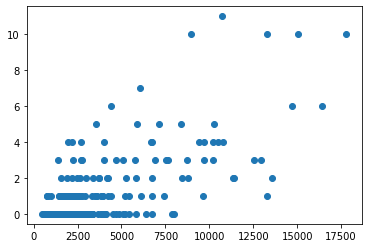

In [149]:
plt.scatter(BA115_DTA_700_n713_omicron_cases_sample_n_epo_1.count_mean,
            BA115_DTA_700_n713_omicron_cases_sample_n_epo_1.sample_n)
plt.show()


In [166]:
X = sm.add_constant(BA115_DTA_700_n713_omicron_cases_sample_n_epo_1.count_mean)
BA115_DTA_700_n713_reg_epo_1 = sm.OLS(
    BA115_DTA_700_n713_omicron_cases_sample_n_epo_1.sample_n,
    X
).fit()
print(BA115_DTA_700_n713_reg_epo_1.summary())
print(BA115_DTA_700_n713_reg_epo_1.params)
BA115_DTA_700_n713_reg_epo_1.resid


                            OLS Regression Results                            
Dep. Variable:               sample_n   R-squared:                       0.467
Model:                            OLS   Adj. R-squared:                  0.465
Method:                 Least Squares   F-statistic:                     194.9
Date:                Sun, 18 Sep 2022   Prob (F-statistic):           3.27e-32
Time:                        19:01:57   Log-Likelihood:                -402.40
No. Observations:                 224   AIC:                             808.8
Df Residuals:                     222   BIC:                             815.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2951      0.148     -1.991      0.0

0      0.048380
1      0.459733
2     -1.274985
3     -0.487465
4     -0.796916
         ...   
219    0.453666
220   -1.864441
221    0.289761
222   -0.460655
223    2.360415
Length: 224, dtype: float64

In [179]:
BA115_DTA_700_n713_omicron_cases_sample_n_epo_1['resid'] = BA115_DTA_700_n713_reg_epo_1.resid
BA115_DTA_700_n713_omicron_cases_sample_n_epo_1


,origin,count_mean,sample_n,resid
0,E06000001,599.088643,0.0,0.048380
1,E06000006,2028.206040,1.0,0.459733
2,E06000007,3811.951833,0.0,-1.274985
3,E06000010,1900.012052,0.0,-0.487465
4,E06000011,2651.296399,0.0,-0.796916
...,...,...,...,...
219,E09000029,6898.530624,3.0,0.453666
220,E09000030,12526.427630,3.0,-1.864441
221,E09000031,9724.257098,4.0,0.289761
222,E09000032,16401.712403,6.0,-0.460655


In [181]:
with open('./BA.1.15_DTA_700_n713/ltla_residual_epo_1.tsv', 'w+') as outfile:
    outfile.write('ltla\tresidual\n')
    outfile.write('\n'.join(['%s\t%s' % (row.origin, row.resid)
                             for index, row in BA115_DTA_700_n713_omicron_cases_sample_n_epo_1.iterrows()]))
    

#### Epoch-2

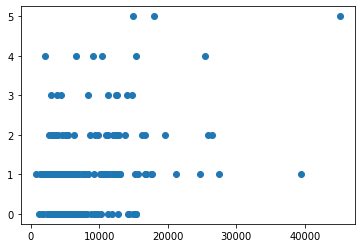

In [150]:
plt.scatter(BA115_DTA_700_n713_omicron_cases_sample_n_epo_2.count_mean,
            BA115_DTA_700_n713_omicron_cases_sample_n_epo_2.sample_n)
plt.show()


In [167]:
X = sm.add_constant(BA115_DTA_700_n713_omicron_cases_sample_n_epo_2.count_mean)
BA115_DTA_700_n713_reg_epo_2 = sm.OLS(
    BA115_DTA_700_n713_omicron_cases_sample_n_epo_2.sample_n,
    X
).fit()
print(BA115_DTA_700_n713_reg_epo_2.summary())
print(BA115_DTA_700_n713_reg_epo_2.params)
BA115_DTA_700_n713_reg_epo_2.resid


                            OLS Regression Results                            
Dep. Variable:               sample_n   R-squared:                       0.134
Model:                            OLS   Adj. R-squared:                  0.130
Method:                 Least Squares   F-statistic:                     34.33
Date:                Sun, 18 Sep 2022   Prob (F-statistic):           1.66e-08
Time:                        19:02:33   Log-Likelihood:                -311.76
No. Observations:                 224   AIC:                             627.5
Df Residuals:                     222   BIC:                             634.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4895      0.107      4.572      0.0

0      0.130521
1     -0.973150
2     -0.175150
3      1.718886
4      1.576008
         ...   
219    0.960995
220   -0.261743
221    0.812332
222   -0.223199
223    1.110433
Length: 224, dtype: float64

In [182]:
BA115_DTA_700_n713_omicron_cases_sample_n_epo_2['resid'] = BA115_DTA_700_n713_reg_epo_2.resid
BA115_DTA_700_n713_omicron_cases_sample_n_epo_2


,origin,count_mean,sample_n,resid
0,E06000001,6013.218639,1.0,0.130521
1,E06000006,7653.898475,0.0,-0.973150
2,E06000007,10850.713185,1.0,-0.175150
3,E06000010,12527.673528,3.0,1.718886
4,E06000011,14788.822581,3.0,1.576008
...,...,...,...,...
219,E09000029,8696.094999,2.0,0.960995
220,E09000030,12221.102257,1.0,-0.261743
221,E09000031,11048.812696,2.0,0.812332
222,E09000032,11611.121439,1.0,-0.223199


In [183]:
with open('./BA.1.15_DTA_700_n713/ltla_residual_epo_2.tsv', 'w+') as outfile:
    outfile.write('ltla\tresidual\n')
    outfile.write('\n'.join(['%s\t%s' % (row.origin, row.resid)
                             for index, row in BA115_DTA_700_n713_omicron_cases_sample_n_epo_2.iterrows()]))
    

#### Epoch-3

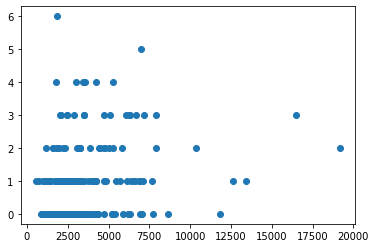

In [151]:
plt.scatter(BA115_DTA_700_n713_omicron_cases_sample_n_epo_3.count_mean,
            BA115_DTA_700_n713_omicron_cases_sample_n_epo_3.sample_n)
plt.show()


In [171]:
X = sm.add_constant(BA115_DTA_700_n713_omicron_cases_sample_n_epo_3.count_mean)
BA115_DTA_700_n713_reg_epo_3 = sm.OLS(
    BA115_DTA_700_n713_omicron_cases_sample_n_epo_3.sample_n,
    X
).fit()
print(BA115_DTA_700_n713_reg_epo_3.summary())
print(BA115_DTA_700_n713_reg_epo_3.params)
BA115_DTA_700_n713_reg_epo_3.resid


                            OLS Regression Results                            
Dep. Variable:               sample_n   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     10.56
Date:                Sun, 18 Sep 2022   Prob (F-statistic):            0.00134
Time:                        19:04:36   Log-Likelihood:                -337.28
No. Observations:                 224   AIC:                             678.6
Df Residuals:                     222   BIC:                             685.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6016      0.127      4.750      0.0

0     -0.794858
1     -0.836582
2     -0.928810
3      0.833298
4      1.795177
         ...   
219    0.013037
220   -1.019555
221   -0.990614
222   -1.120733
223    0.133745
Length: 224, dtype: float64

In [184]:
BA115_DTA_700_n713_omicron_cases_sample_n_epo_3['resid'] = BA115_DTA_700_n713_reg_epo_3.resid
BA115_DTA_700_n713_omicron_cases_sample_n_epo_3


,origin,count_mean,sample_n,resid
0,E06000001,2002.165508,0.0,-0.794858
1,E06000006,2434.531879,0.0,-0.836582
2,E06000007,3390.253717,0.0,-0.928810
3,E06000010,5855.435143,2.0,0.833298
4,E06000011,6250.464547,3.0,1.795177
...,...,...,...,...
219,E09000029,3992.865846,1.0,0.013037
220,E09000030,4330.607922,0.0,-1.019555
221,E09000031,4030.702329,0.0,-0.990614
222,E09000032,5379.078310,0.0,-1.120733


In [185]:
with open('./BA.1.15_DTA_700_n713/ltla_residual_epo_3.tsv', 'w+') as outfile:
    outfile.write('ltla\tresidual\n')
    outfile.write('\n'.join(['%s\t%s' % (row.origin, row.resid)
                             for index, row in BA115_DTA_700_n713_omicron_cases_sample_n_epo_3.iterrows()]))
    

## Merge LTLAs for BA.1.15_DTA_102_n2975

In [187]:
BA115_DTA_102_n2975_mergers_rev_dict = dict(zip(BA115_DTA_102_n2975_mergers_rev.child_ltla.values,
                                                BA115_DTA_102_n2975_mergers_rev.parent_ltla.values))

BA115_DTA_102_n2975_omicron_cases_study = omicron_cases.copy()
BA115_DTA_102_n2975_omicron_cases_study.origin = BA115_DTA_102_n2975_omicron_cases_study.origin.apply(
    lambda x: BA115_DTA_102_n2975_mergers_rev_dict[x] if x in BA115_DTA_102_n2975_mergers_rev_dict else x
)
BA115_DTA_102_n2975_omicron_cases_study = BA115_DTA_102_n2975_omicron_cases_study[
    BA115_DTA_102_n2975_omicron_cases_study.origin.isin(BA115_DTA_102_n2975_tip_ltla.ltla.unique().tolist())]

BA115_DTA_102_n2975_omicron_cases_epo_1 = BA115_DTA_102_n2975_omicron_cases_study[
    (BA115_DTA_102_n2975_omicron_cases_study.epoch == 1) &
    (BA115_DTA_102_n2975_omicron_cases_study.date >= dec2date(BA115_DTA_102_n2975_import_est, get_str=True))
].groupby('origin').agg({'count_mean': 'sum'}).reset_index()

BA115_DTA_102_n2975_omicron_cases_epo_2 = BA115_DTA_102_n2975_omicron_cases_study[
    BA115_DTA_102_n2975_omicron_cases_study.epoch == 2
].groupby('origin').agg({'count_mean': 'sum'}).reset_index()

BA115_DTA_102_n2975_omicron_cases_epo_3 = BA115_DTA_102_n2975_omicron_cases_study[
    BA115_DTA_102_n2975_omicron_cases_study.epoch == 3
].groupby('origin').agg({'count_mean': 'sum'}).reset_index()


In [213]:
BA115_DTA_102_n2975_omicron_cases_sample_n_epo_1 = pd.merge(
    BA115_DTA_102_n2975_omicron_cases_epo_1,
    BA115_DTA_102_n2975_tip_ltla[BA115_DTA_102_n2975_tip_ltla.epoch == 1
                                ].groupby('ltla').count().reset_index().rename(columns={'ltla': 'origin'}),
    on='origin', how='left').rename(columns={'name': 'sample_n'})[['origin', 'count_mean', 'sample_n']]
zero_filled_sample_n_epo_1 = BA115_DTA_102_n2975_omicron_cases_sample_n_epo_1.sample_n.apply(
    lambda x: 0 if pd.isna(x) else x)
BA115_DTA_102_n2975_omicron_cases_sample_n_epo_1.sample_n = zero_filled_sample_n_epo_1

BA115_DTA_102_n2975_omicron_cases_sample_n_epo_2 = pd.merge(
    BA115_DTA_102_n2975_omicron_cases_epo_2,
    BA115_DTA_102_n2975_tip_ltla[BA115_DTA_102_n2975_tip_ltla.epoch == 2
                                ].groupby('ltla').count().reset_index().rename(columns={'ltla': 'origin'}),
    on='origin', how='left').rename(columns={'name': 'sample_n'})[['origin', 'count_mean', 'sample_n']]
zero_filled_sample_n_epo_2 = BA115_DTA_102_n2975_omicron_cases_sample_n_epo_2.sample_n.apply(
    lambda x: 0 if pd.isna(x) else x)
BA115_DTA_102_n2975_omicron_cases_sample_n_epo_2.sample_n = zero_filled_sample_n_epo_2

BA115_DTA_102_n2975_omicron_cases_sample_n_epo_3 = pd.merge(
    BA115_DTA_102_n2975_omicron_cases_epo_3,
    BA115_DTA_102_n2975_tip_ltla[BA115_DTA_102_n2975_tip_ltla.epoch == 3
                                ].groupby('ltla').count().reset_index().rename(columns={'ltla': 'origin'}),
    on='origin', how='left').rename(columns={'name': 'sample_n'})[['origin', 'count_mean', 'sample_n']]
zero_filled_sample_n_epo_3 = BA115_DTA_102_n2975_omicron_cases_sample_n_epo_3.sample_n.apply(
    lambda x: 0 if pd.isna(x) else x)
BA115_DTA_102_n2975_omicron_cases_sample_n_epo_3.sample_n = zero_filled_sample_n_epo_3



#### Epoch-1

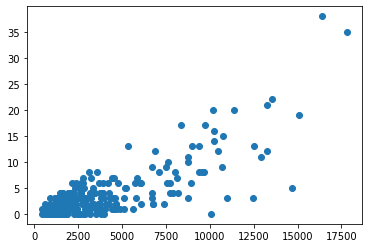

In [221]:
plt.scatter(BA115_DTA_102_n2975_omicron_cases_sample_n_epo_1.count_mean,
            BA115_DTA_102_n2975_omicron_cases_sample_n_epo_1.sample_n)
plt.show()


In [222]:
X = sm.add_constant(BA115_DTA_102_n2975_omicron_cases_sample_n_epo_1.count_mean)
BA115_DTA_102_n2975_reg_epo_1 = sm.OLS(
    BA115_DTA_102_n2975_omicron_cases_sample_n_epo_1.sample_n,
    X
).fit()
print(BA115_DTA_102_n2975_reg_epo_1.summary())
print(BA115_DTA_102_n2975_reg_epo_1.params)
BA115_DTA_102_n2975_reg_epo_1.resid


                            OLS Regression Results                            
Dep. Variable:               sample_n   R-squared:                       0.612
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     395.2
Date:                Mon, 19 Sep 2022   Prob (F-statistic):           1.85e-53
Time:                        00:49:11   Log-Likelihood:                -649.20
No. Observations:                 253   AIC:                             1302.
Df Residuals:                     251   BIC:                             1309.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.8506      0.308     -2.766      0.0

0       0.140843
1       0.915615
2      -0.090542
3      -1.120403
4       1.100071
         ...    
248     4.609866
249    -1.165852
250     6.192136
251    19.190358
252     0.313073
Length: 253, dtype: float64

In [223]:
BA115_DTA_102_n2975_omicron_cases_sample_n_epo_1['resid'] = BA115_DTA_102_n2975_reg_epo_1.resid
BA115_DTA_102_n2975_omicron_cases_sample_n_epo_1


,origin,count_mean,sample_n,resid
0,E06000001,591.299227,0.0,0.140843
1,E06000002,778.934025,1.0,0.915615
2,E06000003,784.063839,0.0,-0.090542
3,E06000004,1642.027968,0.0,-1.120403
4,E06000005,625.266190,1.0,1.100071
...,...,...,...,...
248,E09000029,6865.262705,12.0,4.609866
249,E09000030,12510.029404,13.0,-1.165852
250,E09000031,9712.531218,17.0,6.192136
251,E09000032,16378.712868,38.0,19.190358


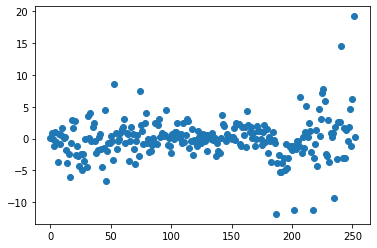

In [224]:
plt.scatter([i for i in range(len(BA115_DTA_102_n2975_omicron_cases_sample_n_epo_1.resid))],
            BA115_DTA_102_n2975_omicron_cases_sample_n_epo_1.resid)


In [225]:
with open('./BA.1.15_DTA_102_n2975/ltla_residual_epo_1.tsv', 'w+') as outfile:
    outfile.write('ltla\tresidual\n')
    outfile.write('\n'.join(['%s\t%s' % (row.origin, row.resid)
                             for index, row in BA115_DTA_102_n2975_omicron_cases_sample_n_epo_1.iterrows()]))
    

#### Epoch-2

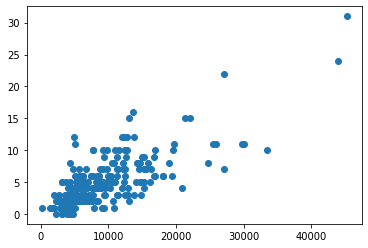

In [226]:
plt.scatter(BA115_DTA_102_n2975_omicron_cases_sample_n_epo_2.count_mean,
            BA115_DTA_102_n2975_omicron_cases_sample_n_epo_2.sample_n)
plt.show()


In [227]:
X = sm.add_constant(BA115_DTA_102_n2975_omicron_cases_sample_n_epo_2.count_mean)
BA115_DTA_102_n2975_reg_epo_2 = sm.OLS(
    BA115_DTA_102_n2975_omicron_cases_sample_n_epo_2.sample_n,
    X
).fit()
print(BA115_DTA_102_n2975_reg_epo_2.summary())
print(BA115_DTA_102_n2975_reg_epo_2.params)
BA115_DTA_102_n2975_reg_epo_2.resid


                            OLS Regression Results                            
Dep. Variable:               sample_n   R-squared:                       0.579
Model:                            OLS   Adj. R-squared:                  0.578
Method:                 Least Squares   F-statistic:                     345.8
Date:                Mon, 19 Sep 2022   Prob (F-statistic):           4.06e-49
Time:                        00:54:52   Log-Likelihood:                -600.19
No. Observations:                 253   AIC:                             1204.
Df Residuals:                     251   BIC:                             1211.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6255      0.278      2.253      0.0

0     -0.444948
1     -2.032855
2      1.321670
3     -2.666259
4     -1.128022
         ...   
248    1.297104
249    1.644299
250    4.193962
251    3.930307
252    2.405988
Length: 253, dtype: float64

In [228]:
BA115_DTA_102_n2975_omicron_cases_sample_n_epo_2['resid'] = BA115_DTA_102_n2975_reg_epo_2.resid
BA115_DTA_102_n2975_omicron_cases_sample_n_epo_2


,origin,count_mean,sample_n,resid
0,E06000001,6013.218639,3.0,-0.444948
1,E06000002,9399.812953,3.0,-2.032855
2,E06000003,8643.702112,6.0,1.321670
3,E06000004,12883.440526,4.0,-2.666259
4,E06000005,5337.296844,2.0,-1.128022
...,...,...,...,...
248,E09000029,8696.094999,6.0,1.297104
249,E09000030,12221.102257,8.0,1.644299
250,E09000031,11048.812696,10.0,4.193962
251,E09000032,11611.121439,10.0,3.930307


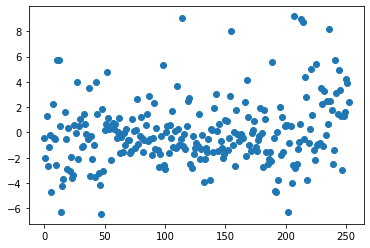

In [229]:
plt.scatter([i for i in range(len(BA115_DTA_102_n2975_omicron_cases_sample_n_epo_2.resid))],
            BA115_DTA_102_n2975_omicron_cases_sample_n_epo_2.resid)


In [230]:
with open('./BA.1.15_DTA_102_n2975/ltla_residual_epo_2.tsv', 'w+') as outfile:
    outfile.write('ltla\tresidual\n')
    outfile.write('\n'.join(['%s\t%s' % (row.origin, row.resid)
                             for index, row in BA115_DTA_102_n2975_omicron_cases_sample_n_epo_2.iterrows()]))
    

#### Epoch-3

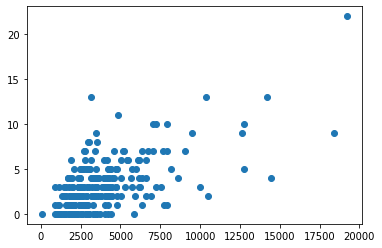

In [231]:
plt.scatter(BA115_DTA_102_n2975_omicron_cases_sample_n_epo_3.count_mean,
            BA115_DTA_102_n2975_omicron_cases_sample_n_epo_3.sample_n)
plt.show()


In [232]:
X = sm.add_constant(BA115_DTA_102_n2975_omicron_cases_sample_n_epo_3.count_mean)
BA115_DTA_102_n2975_reg_epo_3 = sm.OLS(
    BA115_DTA_102_n2975_omicron_cases_sample_n_epo_3.sample_n,
    X
).fit()
print(BA115_DTA_102_n2975_reg_epo_3.summary())
print(BA115_DTA_102_n2975_reg_epo_3.params)
BA115_DTA_102_n2975_reg_epo_3.resid


                            OLS Regression Results                            
Dep. Variable:               sample_n   R-squared:                       0.378
Model:                            OLS   Adj. R-squared:                  0.376
Method:                 Least Squares   F-statistic:                     152.9
Date:                Mon, 19 Sep 2022   Prob (F-statistic):           9.73e-28
Time:                        00:56:04   Log-Likelihood:                -566.80
No. Observations:                 253   AIC:                             1138.
Df Residuals:                     251   BIC:                             1145.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6040      0.251      2.406      0.0

0     -1.926722
1     -2.482234
2     -2.297557
3     -3.497178
4     -1.422311
         ...   
248    0.758117
249   -1.465013
250   -0.266880
251    1.842313
252   -1.415510
Length: 253, dtype: float64

In [233]:
BA115_DTA_102_n2975_omicron_cases_sample_n_epo_3['resid'] = BA115_DTA_102_n2975_reg_epo_3.resid
BA115_DTA_102_n2975_omicron_cases_sample_n_epo_3


,origin,count_mean,sample_n,resid
0,E06000001,2002.165508,0.0,-1.926722
1,E06000002,2843.019016,0.0,-2.482234
2,E06000003,2563.482609,0.0,-2.297557
3,E06000004,4379.295321,0.0,-3.497178
4,E06000005,2752.316726,1.0,-1.422311
...,...,...,...,...
248,E09000029,3992.865846,4.0,0.758117
249,E09000030,4330.607922,2.0,-1.465013
250,E09000031,4030.702329,3.0,-0.266880
251,E09000032,5379.078310,6.0,1.842313


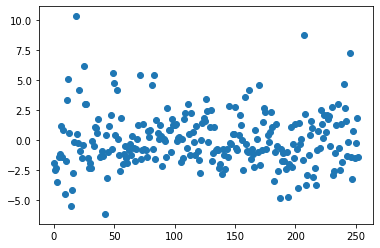

In [234]:
plt.scatter([i for i in range(len(BA115_DTA_102_n2975_omicron_cases_sample_n_epo_3.resid))],
            BA115_DTA_102_n2975_omicron_cases_sample_n_epo_3.resid)


In [235]:
with open('./BA.1.15_DTA_102_n2975/ltla_residual_epo_3.tsv', 'w+') as outfile:
    outfile.write('ltla\tresidual\n')
    outfile.write('\n'.join(['%s\t%s' % (row.origin, row.resid)
                             for index, row in BA115_DTA_102_n2975_omicron_cases_sample_n_epo_3.iterrows()]))
    

## Merge LTLAs for BA.1.17_DTA_175_n11351

In [236]:
BA117_DTA_175_n11351_mergers_rev_dict = dict(zip(BA117_DTA_175_n11351_mergers_rev.child_ltla.values,
                                                 BA117_DTA_175_n11351_mergers_rev.parent_ltla.values))

BA117_DTA_175_n11351_omicron_cases_study = omicron_cases.copy()
BA117_DTA_175_n11351_omicron_cases_study.origin = BA117_DTA_175_n11351_omicron_cases_study.origin.apply(
    lambda x: BA117_DTA_175_n11351_mergers_rev_dict[x] if x in BA117_DTA_175_n11351_mergers_rev_dict else x
)
BA117_DTA_175_n11351_omicron_cases_study = BA117_DTA_175_n11351_omicron_cases_study[
    BA117_DTA_175_n11351_omicron_cases_study.origin.isin(BA117_DTA_175_n11351_tip_ltla.ltla.unique().tolist())]

BA117_DTA_175_n11351_omicron_cases_epo_1 = BA117_DTA_175_n11351_omicron_cases_study[
    (BA117_DTA_175_n11351_omicron_cases_study.epoch == 1) &
    (BA117_DTA_175_n11351_omicron_cases_study.date >= dec2date(BA117_DTA_175_n11351_import_est, get_str=True))
].groupby('origin').agg({'count_mean': 'sum'}).reset_index()

BA117_DTA_175_n11351_omicron_cases_epo_2 = BA117_DTA_175_n11351_omicron_cases_study[
    BA117_DTA_175_n11351_omicron_cases_study.epoch == 2
].groupby('origin').agg({'count_mean': 'sum'}).reset_index()

BA117_DTA_175_n11351_omicron_cases_epo_3 = BA117_DTA_175_n11351_omicron_cases_study[
    BA117_DTA_175_n11351_omicron_cases_study.epoch == 3
].groupby('origin').agg({'count_mean': 'sum'}).reset_index()


In [237]:
BA117_DTA_175_n11351_omicron_cases_sample_n_epo_1 = pd.merge(
    BA117_DTA_175_n11351_omicron_cases_epo_1,
    BA117_DTA_175_n11351_tip_ltla[BA117_DTA_175_n11351_tip_ltla.epoch == 1
                                 ].groupby('ltla').count().reset_index().rename(columns={'ltla': 'origin'}),
    on='origin', how='left').rename(columns={'name': 'sample_n'})[['origin', 'count_mean', 'sample_n']]
zero_filled_sample_n_epo_1 = BA117_DTA_175_n11351_omicron_cases_sample_n_epo_1.sample_n.apply(
    lambda x: 0 if pd.isna(x) else x)
BA117_DTA_175_n11351_omicron_cases_sample_n_epo_1.sample_n = zero_filled_sample_n_epo_1

BA117_DTA_175_n11351_omicron_cases_sample_n_epo_2 = pd.merge(
    BA117_DTA_175_n11351_omicron_cases_epo_2,
    BA117_DTA_175_n11351_tip_ltla[BA117_DTA_175_n11351_tip_ltla.epoch == 2
                                 ].groupby('ltla').count().reset_index().rename(columns={'ltla': 'origin'}),
    on='origin', how='left').rename(columns={'name': 'sample_n'})[['origin', 'count_mean', 'sample_n']]
zero_filled_sample_n_epo_2 = BA117_DTA_175_n11351_omicron_cases_sample_n_epo_2.sample_n.apply(
    lambda x: 0 if pd.isna(x) else x)
BA117_DTA_175_n11351_omicron_cases_sample_n_epo_2.sample_n = zero_filled_sample_n_epo_2

BA117_DTA_175_n11351_omicron_cases_sample_n_epo_3 = pd.merge(
    BA117_DTA_175_n11351_omicron_cases_epo_3,
    BA117_DTA_175_n11351_tip_ltla[BA117_DTA_175_n11351_tip_ltla.epoch == 3
                                 ].groupby('ltla').count().reset_index().rename(columns={'ltla': 'origin'}),
    on='origin', how='left').rename(columns={'name': 'sample_n'})[['origin', 'count_mean', 'sample_n']]
zero_filled_sample_n_epo_3 = BA117_DTA_175_n11351_omicron_cases_sample_n_epo_3.sample_n.apply(
    lambda x: 0 if pd.isna(x) else x)
BA117_DTA_175_n11351_omicron_cases_sample_n_epo_3.sample_n = zero_filled_sample_n_epo_3


#### Epoch-1

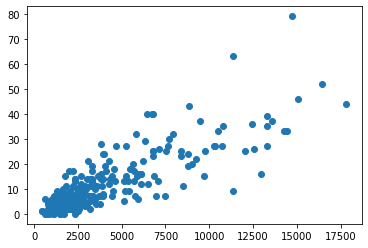

In [245]:
plt.scatter(BA117_DTA_175_n11351_omicron_cases_sample_n_epo_1.count_mean,
            BA117_DTA_175_n11351_omicron_cases_sample_n_epo_1.sample_n)
plt.show()


In [246]:
X = sm.add_constant(BA117_DTA_175_n11351_omicron_cases_sample_n_epo_1.count_mean)
BA117_DTA_175_n11351_reg_epo_1 = sm.OLS(
    BA117_DTA_175_n11351_omicron_cases_sample_n_epo_1.sample_n,
    X
).fit()
print(BA117_DTA_175_n11351_reg_epo_1.summary())
print(BA117_DTA_175_n11351_reg_epo_1.params)
BA117_DTA_175_n11351_reg_epo_1.resid


                            OLS Regression Results                            
Dep. Variable:               sample_n   R-squared:                       0.683
Model:                            OLS   Adj. R-squared:                  0.682
Method:                 Least Squares   F-statistic:                     540.3
Date:                Mon, 19 Sep 2022   Prob (F-statistic):           1.59e-64
Time:                        01:04:09   Log-Likelihood:                -836.39
No. Observations:                 253   AIC:                             1677.
Df Residuals:                     251   BIC:                             1684.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6559      0.637      1.030      0.3

0     -2.354029
1     -0.877916
2     -1.880107
3     -0.283271
4     -2.479512
         ...   
248   -4.443504
249   -9.767009
250   -2.917900
251    5.365496
252    5.363759
Length: 253, dtype: float64

In [247]:
BA117_DTA_175_n11351_omicron_cases_sample_n_epo_1['resid'] = BA117_DTA_175_n11351_reg_epo_1.resid
BA117_DTA_175_n11351_omicron_cases_sample_n_epo_1


,origin,count_mean,sample_n,resid
0,E06000001,607.123093,0.0,-2.354029
1,E06000002,794.423295,2.0,-0.877916
2,E06000003,795.206687,1.0,-1.880107
3,E06000004,1654.386810,5.0,-0.283271
4,E06000005,651.985620,0.0,-2.479512
...,...,...,...,...
248,E09000029,9219.602163,22.0,-4.443504
249,E09000030,12552.945211,26.0,-9.767009
250,E09000031,9746.728561,25.0,-2.917900
251,E09000032,16438.296743,52.0,5.365496


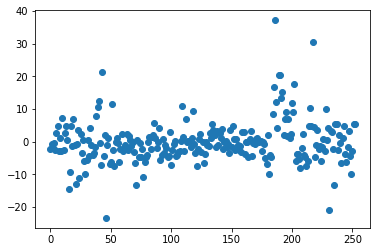

In [249]:
plt.scatter([i for i in range(len(BA117_DTA_175_n11351_omicron_cases_sample_n_epo_1.resid))],
            BA117_DTA_175_n11351_omicron_cases_sample_n_epo_1.resid)


In [250]:
with open('./BA.1.17_DTA_175_n11351/ltla_residual_epo_1.tsv', 'w+') as outfile:
    outfile.write('ltla\tresidual\n')
    outfile.write('\n'.join(['%s\t%s' % (row.origin, row.resid)
                             for index, row in BA117_DTA_175_n11351_omicron_cases_sample_n_epo_1.iterrows()]))
    

#### Epoch-2

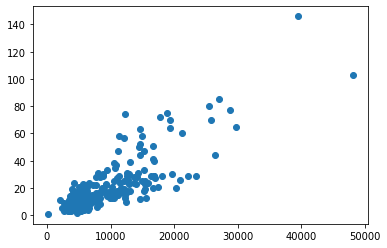

In [251]:
plt.scatter(BA117_DTA_175_n11351_omicron_cases_sample_n_epo_2.count_mean,
            BA117_DTA_175_n11351_omicron_cases_sample_n_epo_2.sample_n)
plt.show()


In [252]:
X = sm.add_constant(BA117_DTA_175_n11351_omicron_cases_sample_n_epo_2.count_mean)
BA117_DTA_175_n11351_reg_epo_2 = sm.OLS(
    BA117_DTA_175_n11351_omicron_cases_sample_n_epo_2.sample_n,
    X
).fit()
print(BA117_DTA_175_n11351_reg_epo_2.summary())
print(BA117_DTA_175_n11351_reg_epo_2.params)
BA117_DTA_175_n11351_reg_epo_2.resid


                            OLS Regression Results                            
Dep. Variable:               sample_n   R-squared:                       0.683
Model:                            OLS   Adj. R-squared:                  0.682
Method:                 Least Squares   F-statistic:                     540.6
Date:                Mon, 19 Sep 2022   Prob (F-statistic):           1.52e-64
Time:                        01:06:43   Log-Likelihood:                -954.17
No. Observations:                 253   AIC:                             1912.
Df Residuals:                     251   BIC:                             1919.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.5052      1.163     -2.155      0.0

0      -0.213878
1      -4.503555
2       1.347247
3       0.969252
4       1.440637
         ...    
248    -9.194276
249   -12.409482
250    -6.539962
251    -5.916376
252    -0.992068
Length: 253, dtype: float64

In [253]:
BA117_DTA_175_n11351_omicron_cases_sample_n_epo_2['resid'] = BA117_DTA_175_n11351_reg_epo_2.resid
BA117_DTA_175_n11351_omicron_cases_sample_n_epo_2


,origin,count_mean,sample_n,resid
0,E06000001,6013.218639,12,-0.213878
1,E06000002,9399.812953,16,-4.503555
2,E06000003,8643.702112,20,1.347247
3,E06000004,12883.440526,30,0.969252
4,E06000005,5337.296844,12,1.440637
...,...,...,...,...
248,E09000029,11724.652113,17,-9.194276
249,E09000030,12221.102257,15,-12.409482
250,E09000031,11048.812696,18,-6.539962
251,E09000032,11611.121439,20,-5.916376


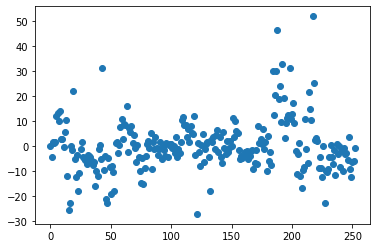

In [256]:
plt.scatter([i for i in range(len(BA117_DTA_175_n11351_omicron_cases_sample_n_epo_2.resid))],
            BA117_DTA_175_n11351_omicron_cases_sample_n_epo_2.resid)


In [257]:
with open('./BA.1.17_DTA_175_n11351/ltla_residual_epo_2.tsv', 'w+') as outfile:
    outfile.write('ltla\tresidual\n')
    outfile.write('\n'.join(['%s\t%s' % (row.origin, row.resid)
                             for index, row in BA117_DTA_175_n11351_omicron_cases_sample_n_epo_2.iterrows()]))
    

#### Epoch-3

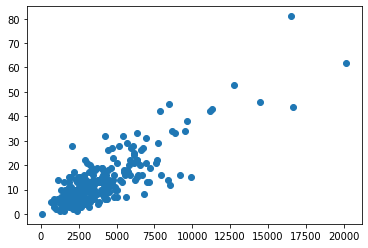

In [258]:
plt.scatter(BA117_DTA_175_n11351_omicron_cases_sample_n_epo_3.count_mean,
            BA117_DTA_175_n11351_omicron_cases_sample_n_epo_3.sample_n)
plt.show()


In [259]:
X = sm.add_constant(BA117_DTA_175_n11351_omicron_cases_sample_n_epo_3.count_mean)
BA117_DTA_175_n11351_reg_epo_3 = sm.OLS(
    BA117_DTA_175_n11351_omicron_cases_sample_n_epo_3.sample_n,
    X
).fit()
print(BA117_DTA_175_n11351_reg_epo_3.summary())
print(BA117_DTA_175_n11351_reg_epo_3.params)
BA117_DTA_175_n11351_reg_epo_3.resid


                            OLS Regression Results                            
Dep. Variable:               sample_n   R-squared:                       0.683
Model:                            OLS   Adj. R-squared:                  0.681
Method:                 Least Squares   F-statistic:                     540.1
Date:                Mon, 19 Sep 2022   Prob (F-statistic):           1.64e-64
Time:                        01:07:55   Log-Likelihood:                -809.04
No. Observations:                 253   AIC:                             1622.
Df Residuals:                     251   BIC:                             1629.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6823      0.660      1.034      0.3

0     -2.115656
1      6.182513
2     -3.919280
3     -1.753850
4      4.473958
         ...   
248   -1.054394
249   -4.597408
250   -5.633751
251   -4.966353
252    0.507036
Length: 253, dtype: float64

In [260]:
BA117_DTA_175_n11351_omicron_cases_sample_n_epo_3['resid'] = BA117_DTA_175_n11351_reg_epo_3.resid
BA117_DTA_175_n11351_omicron_cases_sample_n_epo_3


,origin,count_mean,sample_n,resid
0,E06000001,2002.165508,5.0,-2.115656
1,E06000002,2843.019016,16.0,6.182513
2,E06000003,2563.482609,5.0,-3.919280
3,E06000004,4379.295321,13.0,-1.753850
4,E06000005,2752.316726,14.0,4.473958
...,...,...,...,...
248,E09000029,5717.694466,18.0,-1.054394
249,E09000030,4330.607922,10.0,-4.597408
250,E09000031,4030.702329,8.0,-5.633751
251,E09000032,5379.078310,13.0,-4.966353


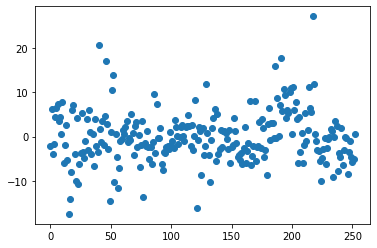

In [261]:
plt.scatter([i for i in range(len(BA117_DTA_175_n11351_omicron_cases_sample_n_epo_3.resid))],
            BA117_DTA_175_n11351_omicron_cases_sample_n_epo_3.resid)


In [262]:
with open('./BA.1.17_DTA_175_n11351/ltla_residual_epo_3.tsv', 'w+') as outfile:
    outfile.write('ltla\tresidual\n')
    outfile.write('\n'.join(['%s\t%s' % (row.origin, row.resid)
                             for index, row in BA117_DTA_175_n11351_omicron_cases_sample_n_epo_3.iterrows()]))
    

## Merge LTLAs for BA.1.1_DTA_1467_n722

no mergers needed

In [263]:
BA11_DTA_1467_n722_omicron_cases_study = omicron_cases[
    omicron_cases.origin.isin(BA11_DTA_1467_n722_tip_ltla.ltla.unique().tolist())].copy()

BA11_DTA_1467_n722_omicron_cases_epo_1 = BA11_DTA_1467_n722_omicron_cases_study[
    (BA11_DTA_1467_n722_omicron_cases_study.epoch == 1) &
    (BA11_DTA_1467_n722_omicron_cases_study.date >= dec2date(BA11_DTA_1467_n722_import_est, get_str=True))
].groupby('origin').agg({'count_mean': 'sum'}).reset_index()

BA11_DTA_1467_n722_omicron_cases_epo_2 = BA11_DTA_1467_n722_omicron_cases_study[
    BA11_DTA_1467_n722_omicron_cases_study.epoch == 2
].groupby('origin').agg({'count_mean': 'sum'}).reset_index()

BA11_DTA_1467_n722_omicron_cases_epo_3 = BA11_DTA_1467_n722_omicron_cases_study[
    BA11_DTA_1467_n722_omicron_cases_study.epoch == 3
].groupby('origin').agg({'count_mean': 'sum'}).reset_index()


In [264]:
BA11_DTA_1467_n722_omicron_cases_sample_n_epo_1 = pd.merge(
    BA11_DTA_1467_n722_omicron_cases_epo_1,
    BA11_DTA_1467_n722_tip_ltla[BA11_DTA_1467_n722_tip_ltla.epoch == 1].groupby('ltla').count().reset_index().rename(
        columns={'ltla': 'origin'}), on='origin', how='left').rename(columns={'name': 'sample_n'})[[
    'origin', 'count_mean', 'sample_n']]
zero_filled_sample_n_epo_1 = BA11_DTA_1467_n722_omicron_cases_sample_n_epo_1.sample_n.apply(
    lambda x: 0 if pd.isna(x) else x)
BA11_DTA_1467_n722_omicron_cases_sample_n_epo_1.sample_n = zero_filled_sample_n_epo_1

BA11_DTA_1467_n722_omicron_cases_sample_n_epo_2 = pd.merge(
    BA11_DTA_1467_n722_omicron_cases_epo_2,
    BA11_DTA_1467_n722_tip_ltla[BA11_DTA_1467_n722_tip_ltla.epoch == 2].groupby('ltla').count().reset_index().rename(
        columns={'ltla': 'origin'}), on='origin', how='left').rename(columns={'name': 'sample_n'})[[
    'origin', 'count_mean', 'sample_n']]
zero_filled_sample_n_epo_2 = BA11_DTA_1467_n722_omicron_cases_sample_n_epo_2.sample_n.apply(
    lambda x: 0 if pd.isna(x) else x)
BA11_DTA_1467_n722_omicron_cases_sample_n_epo_2.sample_n = zero_filled_sample_n_epo_2

BA11_DTA_1467_n722_omicron_cases_sample_n_epo_3 = pd.merge(
    BA11_DTA_1467_n722_omicron_cases_epo_3,
    BA11_DTA_1467_n722_tip_ltla[BA11_DTA_1467_n722_tip_ltla.epoch == 3].groupby('ltla').count().reset_index().rename(
        columns={'ltla': 'origin'}), on='origin', how='left').rename(columns={'name': 'sample_n'})[[
    'origin', 'count_mean', 'sample_n']]
zero_filled_sample_n_epo_3 = BA11_DTA_1467_n722_omicron_cases_sample_n_epo_3.sample_n.apply(
    lambda x: 0 if pd.isna(x) else x)
BA11_DTA_1467_n722_omicron_cases_sample_n_epo_3.sample_n = zero_filled_sample_n_epo_3


#### Epoch-1

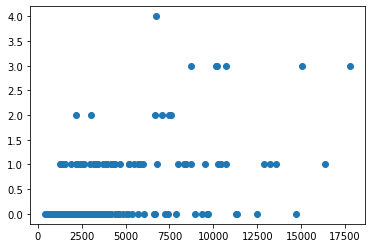

In [273]:
plt.scatter(BA11_DTA_1467_n722_omicron_cases_sample_n_epo_1.count_mean,
            BA11_DTA_1467_n722_omicron_cases_sample_n_epo_1.sample_n)
plt.show()


In [274]:
X = sm.add_constant(BA11_DTA_1467_n722_omicron_cases_sample_n_epo_1.count_mean)
BA11_DTA_1467_n722_reg_epo_1 = sm.OLS(
    BA11_DTA_1467_n722_omicron_cases_sample_n_epo_1.sample_n,
    X
).fit()
print(BA11_DTA_1467_n722_reg_epo_1.summary())
print(BA11_DTA_1467_n722_reg_epo_1.params)
BA11_DTA_1467_n722_reg_epo_1.resid


                            OLS Regression Results                            
Dep. Variable:               sample_n   R-squared:                       0.276
Model:                            OLS   Adj. R-squared:                  0.273
Method:                 Least Squares   F-statistic:                     81.57
Date:                Mon, 19 Sep 2022   Prob (F-statistic):           1.01e-16
Time:                        01:14:31   Log-Likelihood:                -198.29
No. Observations:                 216   AIC:                             400.6
Df Residuals:                     214   BIC:                             407.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0687      0.063     -1.095      0.2

0     -0.019342
1     -0.019912
2     -0.001539
3     -0.146224
4     -0.231444
         ...   
211    0.295491
212   -1.351626
213   -1.033829
214   -0.790297
215    1.262930
Length: 216, dtype: float64

In [275]:
BA11_DTA_1467_n722_omicron_cases_sample_n_epo_1['resid'] = BA11_DTA_1467_n722_reg_epo_1.resid
BA11_DTA_1467_n722_omicron_cases_sample_n_epo_1


,origin,count_mean,sample_n,resid
0,E06000002,773.730542,0.0,-0.019342
1,E06000003,778.737777,0.0,-0.019912
2,E06000005,617.202042,0.0,-0.001539
3,E06000010,1889.318082,0.0,-0.146224
4,E06000011,2638.598578,0.0,-0.231444
...,...,...,...,...
211,E09000029,6797.947106,1.0,0.295491
212,E09000030,12487.614215,0.0,-1.351626
213,E09000031,9693.438623,0.0,-1.033829
214,E09000032,16344.555217,1.0,-0.790297


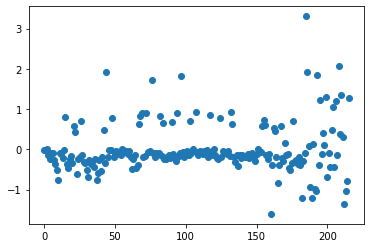

In [276]:
plt.scatter([i for i in range(len(BA11_DTA_1467_n722_omicron_cases_sample_n_epo_1.resid))],
            BA11_DTA_1467_n722_omicron_cases_sample_n_epo_1.resid)


In [277]:
with open('./BA.1.1_DTA_1467_n722/ltla_residual_epo_1.tsv', 'w+') as outfile:
    outfile.write('ltla\tresidual\n')
    outfile.write('\n'.join(['%s\t%s' % (row.origin, row.resid)
                             for index, row in BA11_DTA_1467_n722_omicron_cases_sample_n_epo_1.iterrows()]))
    

#### Epoch-2

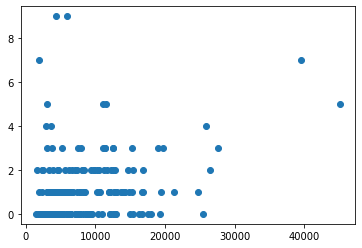

In [278]:
plt.scatter(BA11_DTA_1467_n722_omicron_cases_sample_n_epo_2.count_mean,
            BA11_DTA_1467_n722_omicron_cases_sample_n_epo_2.sample_n)
plt.show()


In [279]:
X = sm.add_constant(BA11_DTA_1467_n722_omicron_cases_sample_n_epo_2.count_mean)
BA11_DTA_1467_n722_reg_epo_2 = sm.OLS(
    BA11_DTA_1467_n722_omicron_cases_sample_n_epo_2.sample_n,
    X
).fit()
print(BA11_DTA_1467_n722_reg_epo_2.summary())
print(BA11_DTA_1467_n722_reg_epo_2.params)
BA11_DTA_1467_n722_reg_epo_2.resid


                            OLS Regression Results                            
Dep. Variable:               sample_n   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     17.04
Date:                Mon, 19 Sep 2022   Prob (F-statistic):           5.24e-05
Time:                        01:16:31   Log-Likelihood:                -380.17
No. Observations:                 216   AIC:                             764.3
Df Residuals:                     214   BIC:                             771.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5882      0.159      3.699      0.0

0      0.804946
1     -1.146241
2     -0.932785
3      0.603017
4     -0.542960
         ...   
211   -1.149623
212    0.622808
213    3.698489
214    0.662188
215   -0.996945
Length: 216, dtype: float64

In [280]:
BA11_DTA_1467_n722_omicron_cases_sample_n_epo_2['resid'] = BA11_DTA_1467_n722_reg_epo_2.resid
BA11_DTA_1467_n722_omicron_cases_sample_n_epo_2


,origin,count_mean,sample_n,resid
0,E06000002,9399.812953,2.0,0.804946
1,E06000003,8643.702112,0.0,-1.146241
2,E06000005,5337.296844,0.0,-0.932785
3,E06000010,12527.673528,2.0,0.603017
4,E06000011,14788.822581,1.0,-0.542960
...,...,...,...,...
211,E09000029,8696.094999,0.0,-1.149623
212,E09000030,12221.102257,2.0,0.622808
213,E09000031,11048.812696,5.0,3.698489
214,E09000032,11611.121439,2.0,0.662188


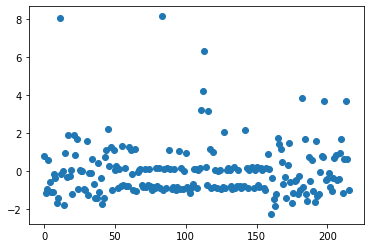

In [281]:
plt.scatter([i for i in range(len(BA11_DTA_1467_n722_omicron_cases_sample_n_epo_2.resid))],
            BA11_DTA_1467_n722_omicron_cases_sample_n_epo_2.resid)


In [282]:
with open('./BA.1.1_DTA_1467_n722/ltla_residual_epo_2.tsv', 'w+') as outfile:
    outfile.write('ltla\tresidual\n')
    outfile.write('\n'.join(['%s\t%s' % (row.origin, row.resid)
                             for index, row in BA11_DTA_1467_n722_omicron_cases_sample_n_epo_2.iterrows()]))
    

#### Epoch-3

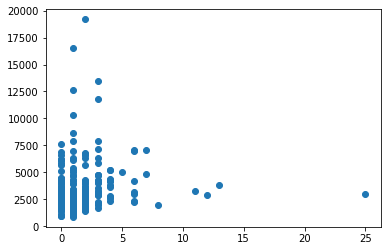

In [287]:
plt.scatter(BA11_DTA_1467_n722_omicron_cases_sample_n_epo_3.sample_n,
            BA11_DTA_1467_n722_omicron_cases_sample_n_epo_3.count_mean)
plt.show()


In [288]:
X = sm.add_constant(BA11_DTA_1467_n722_omicron_cases_sample_n_epo_3.count_mean)
BA11_DTA_1467_n722_reg_epo_3 = sm.OLS(
    BA11_DTA_1467_n722_omicron_cases_sample_n_epo_3.sample_n,
    X
).fit()
print(BA11_DTA_1467_n722_reg_epo_3.summary())
print(BA11_DTA_1467_n722_reg_epo_3.params)
BA11_DTA_1467_n722_reg_epo_3.resid


                            OLS Regression Results                            
Dep. Variable:               sample_n   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9912
Date:                Mon, 19 Sep 2022   Prob (F-statistic):              0.321
Time:                        01:30:11   Log-Likelihood:                -507.35
No. Observations:                 216   AIC:                             1019.
Df Residuals:                     214   BIC:                             1025.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.6173      0.311      5.193      0.0

0     -1.819769
1     -0.799863
2      0.186690
3     -2.034288
4     -2.062418
         ...   
211    1.098348
212    0.074297
213    0.095654
214   -1.000366
215   -1.812577
Length: 216, dtype: float64

In [289]:
BA11_DTA_1467_n722_omicron_cases_sample_n_epo_3['resid'] = BA11_DTA_1467_n722_reg_epo_3.resid
BA11_DTA_1467_n722_omicron_cases_sample_n_epo_3


,origin,count_mean,sample_n,resid
0,E06000002,2843.019016,0.0,-1.819769
1,E06000003,2563.482609,1.0,-0.799863
2,E06000005,2752.316726,2.0,0.186690
3,E06000010,5855.435143,0.0,-2.034288
4,E06000011,6250.464547,0.0,-2.062418
...,...,...,...,...
211,E09000029,3992.865846,3.0,1.098348
212,E09000030,4330.607922,2.0,0.074297
213,E09000031,4030.702329,2.0,0.095654
214,E09000032,5379.078310,1.0,-1.000366


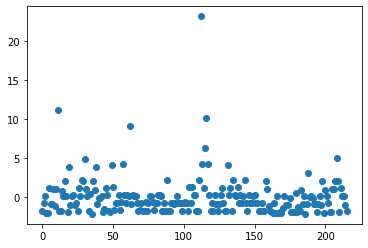

In [290]:
plt.scatter([i for i in range(len(BA11_DTA_1467_n722_omicron_cases_sample_n_epo_3.resid))],
            BA11_DTA_1467_n722_omicron_cases_sample_n_epo_3.resid)


In [291]:
with open('./BA.1.1_DTA_1467_n722/ltla_residual_epo_3.tsv', 'w+') as outfile:
    outfile.write('ltla\tresidual\n')
    outfile.write('\n'.join(['%s\t%s' % (row.origin, row.resid)
                             for index, row in BA11_DTA_1467_n722_omicron_cases_sample_n_epo_3.iterrows()]))
    

## Merge LTLAs for BA.1.1_DTA_1254_n2249

In [292]:
BA11_DTA_1254_n2249_mergers_rev_dict = dict(zip(BA11_DTA_1254_n2249_mergers_rev.child_ltla.values,
                                                BA11_DTA_1254_n2249_mergers_rev.parent_ltla.values))

BA11_DTA_1254_n2249_omicron_cases_study = omicron_cases.copy()
BA11_DTA_1254_n2249_omicron_cases_study.origin = BA11_DTA_1254_n2249_omicron_cases_study.origin.apply(
    lambda x: BA11_DTA_1254_n2249_mergers_rev_dict[x] if x in BA11_DTA_1254_n2249_mergers_rev_dict else x
)
BA11_DTA_1254_n2249_omicron_cases_study = BA11_DTA_1254_n2249_omicron_cases_study[
    BA11_DTA_1254_n2249_omicron_cases_study.origin.isin(BA11_DTA_1254_n2249_tip_ltla.ltla.unique().tolist())]

BA11_DTA_1254_n2249_omicron_cases_epo_1 = BA11_DTA_1254_n2249_omicron_cases_study[
    (BA11_DTA_1254_n2249_omicron_cases_study.epoch == 1) &
    (BA11_DTA_1254_n2249_omicron_cases_study.date >= dec2date(BA11_DTA_1254_n2249_import_est, get_str=True))
].groupby('origin').agg({'count_mean': 'sum'}).reset_index()

BA11_DTA_1254_n2249_omicron_cases_epo_2 = BA11_DTA_1254_n2249_omicron_cases_study[
    BA11_DTA_1254_n2249_omicron_cases_study.epoch == 2
].groupby('origin').agg({'count_mean': 'sum'}).reset_index()

BA11_DTA_1254_n2249_omicron_cases_epo_3 = BA11_DTA_1254_n2249_omicron_cases_study[
    BA11_DTA_1254_n2249_omicron_cases_study.epoch == 3
].groupby('origin').agg({'count_mean': 'sum'}).reset_index()


In [293]:
BA11_DTA_1254_n2249_omicron_cases_sample_n_epo_1 = pd.merge(
    BA11_DTA_1254_n2249_omicron_cases_epo_1,
    BA11_DTA_1254_n2249_tip_ltla[BA11_DTA_1254_n2249_tip_ltla.epoch == 1
                                ].groupby('ltla').count().reset_index().rename(columns={'ltla': 'origin'}),
    on='origin', how='left').rename(columns={'name': 'sample_n'})[['origin', 'count_mean', 'sample_n']]
zero_filled_sample_n_epo_1 = BA11_DTA_1254_n2249_omicron_cases_sample_n_epo_1.sample_n.apply(
    lambda x: 0 if pd.isna(x) else x)
BA11_DTA_1254_n2249_omicron_cases_sample_n_epo_1.sample_n = zero_filled_sample_n_epo_1

BA11_DTA_1254_n2249_omicron_cases_sample_n_epo_2 = pd.merge(
    BA11_DTA_1254_n2249_omicron_cases_epo_2,
    BA11_DTA_1254_n2249_tip_ltla[BA11_DTA_1254_n2249_tip_ltla.epoch == 2
                                ].groupby('ltla').count().reset_index().rename(columns={'ltla': 'origin'}),
    on='origin', how='left').rename(columns={'name': 'sample_n'})[['origin', 'count_mean', 'sample_n']]
zero_filled_sample_n_epo_2 = BA11_DTA_1254_n2249_omicron_cases_sample_n_epo_2.sample_n.apply(
    lambda x: 0 if pd.isna(x) else x)
BA11_DTA_1254_n2249_omicron_cases_sample_n_epo_2.sample_n = zero_filled_sample_n_epo_2

BA11_DTA_1254_n2249_omicron_cases_sample_n_epo_3 = pd.merge(
    BA11_DTA_1254_n2249_omicron_cases_epo_3,
    BA11_DTA_1254_n2249_tip_ltla[BA11_DTA_1254_n2249_tip_ltla.epoch == 3
                                ].groupby('ltla').count().reset_index().rename(columns={'ltla': 'origin'}),
    on='origin', how='left').rename(columns={'name': 'sample_n'})[['origin', 'count_mean', 'sample_n']]
zero_filled_sample_n_epo_3 = BA11_DTA_1254_n2249_omicron_cases_sample_n_epo_3.sample_n.apply(
    lambda x: 0 if pd.isna(x) else x)
BA11_DTA_1254_n2249_omicron_cases_sample_n_epo_3.sample_n = zero_filled_sample_n_epo_3


#### Epoch-1

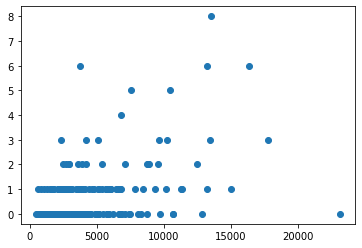

In [302]:
plt.scatter(BA11_DTA_1254_n2249_omicron_cases_sample_n_epo_1.count_mean,
            BA11_DTA_1254_n2249_omicron_cases_sample_n_epo_1.sample_n)
plt.show()


In [303]:
X = sm.add_constant(BA11_DTA_1254_n2249_omicron_cases_sample_n_epo_1.count_mean)
BA11_DTA_1254_n2249_reg_epo_1 = sm.OLS(
    BA11_DTA_1254_n2249_omicron_cases_sample_n_epo_1.sample_n,
    X
).fit()
print(BA11_DTA_1254_n2249_reg_epo_1.summary())
print(BA11_DTA_1254_n2249_reg_epo_1.params)
BA11_DTA_1254_n2249_reg_epo_1.resid


                            OLS Regression Results                            
Dep. Variable:               sample_n   R-squared:                       0.236
Model:                            OLS   Adj. R-squared:                  0.233
Method:                 Least Squares   F-statistic:                     77.37
Date:                Mon, 19 Sep 2022   Prob (F-statistic):           2.32e-16
Time:                        01:35:15   Log-Likelihood:                -358.26
No. Observations:                 253   AIC:                             720.5
Df Residuals:                     251   BIC:                             727.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0312      0.095     -0.329      0.7

0      0.935707
1     -0.094876
2     -0.095692
3     -0.235535
4     -0.069364
         ...   
248    2.923230
249   -0.004136
250   -1.548710
251    3.367217
252    0.876567
Length: 253, dtype: float64

In [304]:
BA11_DTA_1254_n2249_omicron_cases_sample_n_epo_1['resid'] = BA11_DTA_1254_n2249_reg_epo_1.resid
BA11_DTA_1254_n2249_omicron_cases_sample_n_epo_1


,origin,count_mean,sample_n,resid
0,E06000001,586.092394,1.0,0.935707
1,E06000002,773.730542,0.0,-0.094876
2,E06000003,778.737777,0.0,-0.095692
3,E06000004,1636.714692,0.0,-0.235535
4,E06000005,617.202042,0.0,-0.069364
...,...,...,...,...
248,E09000029,6797.947106,4.0,2.923230
249,E09000030,12487.614215,2.0,-0.004136
250,E09000031,9693.438623,0.0,-1.548710
251,E09000032,16344.555217,6.0,3.367217


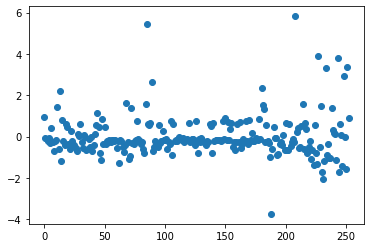

In [305]:
plt.scatter([i for i in range(len(BA11_DTA_1254_n2249_omicron_cases_sample_n_epo_1.resid))],
            BA11_DTA_1254_n2249_omicron_cases_sample_n_epo_1.resid)


In [306]:
with open('./BA.1.1_DTA_1254_n2249/ltla_residual_epo_1.tsv', 'w+') as outfile:
    outfile.write('ltla\tresidual\n')
    outfile.write('\n'.join(['%s\t%s' % (row.origin, row.resid)
                             for index, row in BA11_DTA_1254_n2249_omicron_cases_sample_n_epo_1.iterrows()]))
    

#### Epoch-2

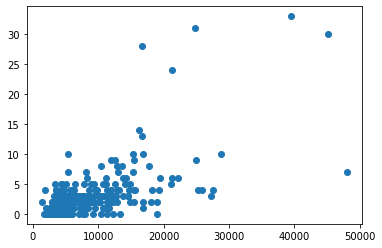

In [307]:
plt.scatter(BA11_DTA_1254_n2249_omicron_cases_sample_n_epo_2.count_mean,
            BA11_DTA_1254_n2249_omicron_cases_sample_n_epo_2.sample_n)
plt.show()


In [308]:
X = sm.add_constant(BA11_DTA_1254_n2249_omicron_cases_sample_n_epo_2.count_mean)
BA11_DTA_1254_n2249_reg_epo_2 = sm.OLS(
    BA11_DTA_1254_n2249_omicron_cases_sample_n_epo_2.sample_n,
    X
).fit()
print(BA11_DTA_1254_n2249_reg_epo_2.summary())
print(BA11_DTA_1254_n2249_reg_epo_2.params)
BA11_DTA_1254_n2249_reg_epo_2.resid


                            OLS Regression Results                            
Dep. Variable:               sample_n   R-squared:                       0.381
Model:                            OLS   Adj. R-squared:                  0.379
Method:                 Least Squares   F-statistic:                     154.6
Date:                Mon, 19 Sep 2022   Prob (F-statistic):           5.57e-28
Time:                        01:36:56   Log-Likelihood:                -674.22
No. Observations:                 253   AIC:                             1352.
Df Residuals:                     251   BIC:                             1360.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3924      0.364     -1.078      0.2

0     -2.054739
1      1.567057
2      0.874763
3      3.149363
4      0.220334
         ...   
248   -1.146559
249   -4.581092
250    0.895981
251   -1.332855
252    1.815883
Length: 253, dtype: float64

In [309]:
BA11_DTA_1254_n2249_omicron_cases_sample_n_epo_2['resid'] = BA11_DTA_1254_n2249_reg_epo_2.resid
BA11_DTA_1254_n2249_omicron_cases_sample_n_epo_2


,origin,count_mean,sample_n,resid
0,E06000001,6013.218639,0.0,-2.054739
1,E06000002,9399.812953,5.0,1.567057
2,E06000003,8643.702112,4.0,0.874763
3,E06000004,12883.440526,8.0,3.149363
4,E06000005,5337.296844,2.0,0.220334
...,...,...,...,...
248,E09000029,8696.094999,2.0,-1.146559
249,E09000030,12221.102257,0.0,-4.581092
250,E09000031,11048.812696,5.0,0.895981
251,E09000032,11611.121439,3.0,-1.332855


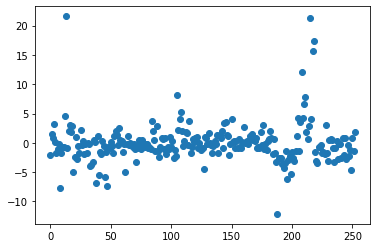

In [310]:
plt.scatter([i for i in range(len(BA11_DTA_1254_n2249_omicron_cases_sample_n_epo_2.resid))],
            BA11_DTA_1254_n2249_omicron_cases_sample_n_epo_2.resid)


In [311]:
with open('./BA.1.1_DTA_1254_n2249/ltla_residual_epo_2.tsv', 'w+') as outfile:
    outfile.write('ltla\tresidual\n')
    outfile.write('\n'.join(['%s\t%s' % (row.origin, row.resid)
                             for index, row in BA11_DTA_1254_n2249_omicron_cases_sample_n_epo_2.iterrows()]))
    

#### Epoch-3

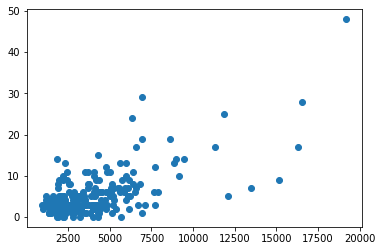

In [312]:
plt.scatter(BA11_DTA_1254_n2249_omicron_cases_sample_n_epo_3.count_mean,
            BA11_DTA_1254_n2249_omicron_cases_sample_n_epo_3.sample_n)
plt.show()


In [313]:
X = sm.add_constant(BA11_DTA_1254_n2249_omicron_cases_sample_n_epo_3.count_mean)
BA11_DTA_1254_n2249_reg_epo_3 = sm.OLS(
    BA11_DTA_1254_n2249_omicron_cases_sample_n_epo_3.sample_n,
    X
).fit()
print(BA11_DTA_1254_n2249_reg_epo_3.summary())
print(BA11_DTA_1254_n2249_reg_epo_3.params)
BA11_DTA_1254_n2249_reg_epo_3.resid


                            OLS Regression Results                            
Dep. Variable:               sample_n   R-squared:                       0.443
Model:                            OLS   Adj. R-squared:                  0.440
Method:                 Least Squares   F-statistic:                     199.3
Date:                Mon, 19 Sep 2022   Prob (F-statistic):           1.05e-33
Time:                        01:37:42   Log-Likelihood:                -707.27
No. Observations:                 253   AIC:                             1419.
Df Residuals:                     251   BIC:                             1426.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0101      0.439     -0.023      0.9

0      0.345676
1     -2.773315
2     -0.401314
3     -3.817762
4     -2.652610
         ...   
248   -2.303509
249    0.247030
250   -0.353861
251   -5.148254
252   -0.638911
Length: 253, dtype: float64

In [314]:
BA11_DTA_1254_n2249_omicron_cases_sample_n_epo_3['resid'] = BA11_DTA_1254_n2249_reg_epo_3.resid
BA11_DTA_1254_n2249_omicron_cases_sample_n_epo_3


,origin,count_mean,sample_n,resid
0,E06000001,2002.165508,3.0,0.345676
1,E06000002,2843.019016,1.0,-2.773315
2,E06000003,2563.482609,3.0,-0.401314
3,E06000004,4379.295321,2.0,-3.817762
4,E06000005,2752.316726,1.0,-2.652610
...,...,...,...,...
248,E09000029,3992.865846,3.0,-2.303509
249,E09000030,4330.607922,6.0,0.247030
250,E09000031,4030.702329,5.0,-0.353861
251,E09000032,5379.078310,2.0,-5.148254


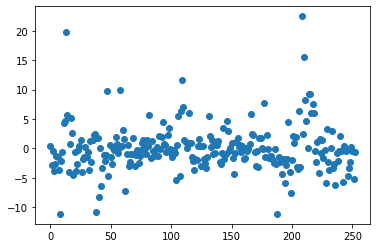

In [315]:
plt.scatter([i for i in range(len(BA11_DTA_1254_n2249_omicron_cases_sample_n_epo_3.resid))],
            BA11_DTA_1254_n2249_omicron_cases_sample_n_epo_3.resid)


In [316]:
with open('./BA.1.1_DTA_1254_n2249/ltla_residual_epo_3.tsv', 'w+') as outfile:
    outfile.write('ltla\tresidual\n')
    outfile.write('\n'.join(['%s\t%s' % (row.origin, row.resid)
                             for index, row in BA11_DTA_1254_n2249_omicron_cases_sample_n_epo_3.iterrows()]))
    

## Merge LTLAs for BA.1_DTA_1944_n1406

In [318]:
BA1_DTA_1944_n1406_mergers_rev_dict = dict(zip(BA1_DTA_1944_n1406_mergers_rev.child_ltla.values,
                                               BA1_DTA_1944_n1406_mergers_rev.parent_ltla.values))

BA1_DTA_1944_n1406_omicron_cases_study = omicron_cases.copy()
BA1_DTA_1944_n1406_omicron_cases_study.origin = BA1_DTA_1944_n1406_omicron_cases_study.origin.apply(
    lambda x: BA1_DTA_1944_n1406_mergers_rev_dict[x] if x in BA1_DTA_1944_n1406_mergers_rev_dict else x
)
BA1_DTA_1944_n1406_omicron_cases_study = BA1_DTA_1944_n1406_omicron_cases_study[
    BA1_DTA_1944_n1406_omicron_cases_study.origin.isin(BA1_DTA_1944_n1406_tip_ltla.ltla.unique().tolist())]

BA1_DTA_1944_n1406_omicron_cases_epo_1 = BA1_DTA_1944_n1406_omicron_cases_study[
    (BA1_DTA_1944_n1406_omicron_cases_study.epoch == 1) &
    (BA1_DTA_1944_n1406_omicron_cases_study.date >= dec2date(BA1_DTA_1944_n1406_import_est, get_str=True))
].groupby('origin').agg({'count_mean': 'sum'}).reset_index()

BA1_DTA_1944_n1406_omicron_cases_epo_2 = BA1_DTA_1944_n1406_omicron_cases_study[
    BA1_DTA_1944_n1406_omicron_cases_study.epoch == 2
].groupby('origin').agg({'count_mean': 'sum'}).reset_index()

BA1_DTA_1944_n1406_omicron_cases_epo_3 = BA1_DTA_1944_n1406_omicron_cases_study[
    BA1_DTA_1944_n1406_omicron_cases_study.epoch == 3
].groupby('origin').agg({'count_mean': 'sum'}).reset_index()


In [319]:
BA1_DTA_1944_n1406_omicron_cases_sample_n_epo_1 = pd.merge(
    BA1_DTA_1944_n1406_omicron_cases_epo_1,
    BA1_DTA_1944_n1406_tip_ltla[BA1_DTA_1944_n1406_tip_ltla.epoch == 1
                               ].groupby('ltla').count().reset_index().rename(columns={'ltla': 'origin'}),
    on='origin', how='left').rename(columns={'name': 'sample_n'})[['origin', 'count_mean', 'sample_n']]
zero_filled_sample_n_epo_1 = BA1_DTA_1944_n1406_omicron_cases_sample_n_epo_1.sample_n.apply(
    lambda x: 0 if pd.isna(x) else x)
BA1_DTA_1944_n1406_omicron_cases_sample_n_epo_1.sample_n = zero_filled_sample_n_epo_1

BA1_DTA_1944_n1406_omicron_cases_sample_n_epo_2 = pd.merge(
    BA1_DTA_1944_n1406_omicron_cases_epo_2,
    BA1_DTA_1944_n1406_tip_ltla[BA1_DTA_1944_n1406_tip_ltla.epoch == 2
                               ].groupby('ltla').count().reset_index().rename(columns={'ltla': 'origin'}),
    on='origin', how='left').rename(columns={'name': 'sample_n'})[['origin', 'count_mean', 'sample_n']]
zero_filled_sample_n_epo_2 = BA1_DTA_1944_n1406_omicron_cases_sample_n_epo_2.sample_n.apply(
    lambda x: 0 if pd.isna(x) else x)
BA1_DTA_1944_n1406_omicron_cases_sample_n_epo_2.sample_n = zero_filled_sample_n_epo_2

BA1_DTA_1944_n1406_omicron_cases_sample_n_epo_3 = pd.merge(
    BA1_DTA_1944_n1406_omicron_cases_epo_2,
    BA1_DTA_1944_n1406_tip_ltla[BA1_DTA_1944_n1406_tip_ltla.epoch == 3
                               ].groupby('ltla').count().reset_index().rename(columns={'ltla': 'origin'}),
    on='origin', how='left').rename(columns={'name': 'sample_n'})[['origin', 'count_mean', 'sample_n']]
zero_filled_sample_n_epo_3 = BA1_DTA_1944_n1406_omicron_cases_sample_n_epo_3.sample_n.apply(
    lambda x: 0 if pd.isna(x) else x)
BA1_DTA_1944_n1406_omicron_cases_sample_n_epo_3.sample_n = zero_filled_sample_n_epo_3


#### Epoch-1

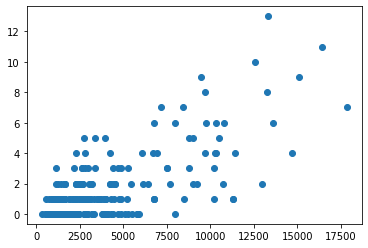

In [332]:
plt.scatter(BA1_DTA_1944_n1406_omicron_cases_sample_n_epo_1.count_mean,
            BA1_DTA_1944_n1406_omicron_cases_sample_n_epo_1.sample_n)
plt.show()


In [333]:
X = sm.add_constant(BA1_DTA_1944_n1406_omicron_cases_sample_n_epo_1.count_mean)
BA1_DTA_1944_n1406_reg_epo_1 = sm.OLS(
    BA1_DTA_1944_n1406_omicron_cases_sample_n_epo_1.sample_n,
    X
).fit()
print(BA1_DTA_1944_n1406_reg_epo_1.summary())
print(BA1_DTA_1944_n1406_reg_epo_1.params)
BA1_DTA_1944_n1406_reg_epo_1.resid


                            OLS Regression Results                            
Dep. Variable:               sample_n   R-squared:                       0.511
Model:                            OLS   Adj. R-squared:                  0.509
Method:                 Least Squares   F-statistic:                     261.8
Date:                Mon, 19 Sep 2022   Prob (F-statistic):           7.99e-41
Time:                        01:44:24   Log-Likelihood:                -458.51
No. Observations:                 253   AIC:                             921.0
Df Residuals:                     251   BIC:                             928.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2294      0.142     -1.612      0.1

0     -0.048930
1      0.470939
2     -0.069498
3     -0.703404
4     -1.521086
         ...   
248    1.051941
249    4.474360
250    1.760904
251    3.693072
252    3.954439
Length: 253, dtype: float64

In [334]:
BA1_DTA_1944_n1406_omicron_cases_sample_n_epo_1['resid'] = BA1_DTA_1944_n1406_reg_epo_1.resid
BA1_DTA_1944_n1406_omicron_cases_sample_n_epo_1


,origin,count_mean,sample_n,resid
0,E06000001,607.123093,0.0,-0.048930
1,E06000004,1654.386810,1.0,0.470939
2,E06000005,651.985620,0.0,-0.069498
3,E06000006,2034.663937,0.0,-0.703404
4,E06000007,3818.194655,0.0,-1.521086
...,...,...,...,...
248,E09000029,6930.713771,4.0,1.051941
249,E09000030,12552.945211,10.0,4.474360
250,E09000031,9746.728561,6.0,1.760904
251,E09000032,16438.296743,11.0,3.693072


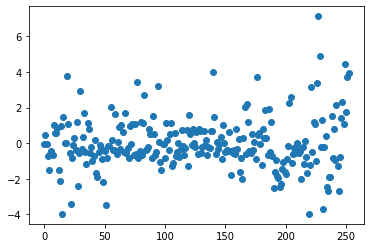

In [335]:
plt.scatter([i for i in range(len(BA1_DTA_1944_n1406_omicron_cases_sample_n_epo_1.resid))],
            BA1_DTA_1944_n1406_omicron_cases_sample_n_epo_1.resid)


In [336]:
with open('./BA.1_DTA_1944_n1406/ltla_residual_epo_1.tsv', 'w+') as outfile:
    outfile.write('ltla\tresidual\n')
    outfile.write('\n'.join(['%s\t%s' % (row.origin, row.resid)
                             for index, row in BA1_DTA_1944_n1406_omicron_cases_sample_n_epo_1.iterrows()]))
    

#### Epoch-2

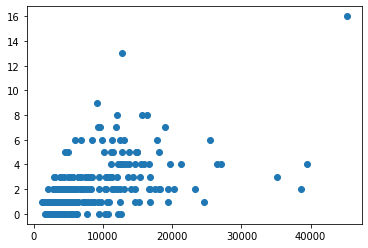

In [337]:
plt.scatter(BA1_DTA_1944_n1406_omicron_cases_sample_n_epo_2.count_mean,
            BA1_DTA_1944_n1406_omicron_cases_sample_n_epo_2.sample_n)
plt.show()


In [338]:
X = sm.add_constant(BA1_DTA_1944_n1406_omicron_cases_sample_n_epo_2.count_mean)
BA1_DTA_1944_n1406_reg_epo_2 = sm.OLS(
    BA1_DTA_1944_n1406_omicron_cases_sample_n_epo_2.sample_n,
    X
).fit()
print(BA1_DTA_1944_n1406_reg_epo_2.summary())
print(BA1_DTA_1944_n1406_reg_epo_2.params)
BA1_DTA_1944_n1406_reg_epo_2.resid


                            OLS Regression Results                            
Dep. Variable:               sample_n   R-squared:                       0.272
Model:                            OLS   Adj. R-squared:                  0.269
Method:                 Least Squares   F-statistic:                     93.84
Date:                Mon, 19 Sep 2022   Prob (F-statistic):           4.66e-19
Time:                        01:45:41   Log-Likelihood:                -508.88
No. Observations:                 253   AIC:                             1022.
Df Residuals:                     251   BIC:                             1029.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7894      0.185      4.264      0.0

0     -0.801534
1      1.042124
2     -0.687768
3     -0.077680
4     -1.615743
         ...   
248   -1.253095
249   -2.846396
250    0.350914
251   -0.743729
252    0.144957
Length: 253, dtype: float64

In [339]:
BA1_DTA_1944_n1406_omicron_cases_sample_n_epo_2['resid'] = BA1_DTA_1944_n1406_reg_epo_2.resid
BA1_DTA_1944_n1406_omicron_cases_sample_n_epo_2


,origin,count_mean,sample_n,resid
0,E06000001,6013.218639,1.0,-0.801534
1,E06000004,12883.440526,4.0,1.042124
2,E06000005,5337.296844,1.0,-0.687768
3,E06000006,7653.898475,2.0,-0.077680
4,E06000007,10850.713185,1.0,-1.615743
...,...,...,...,...
248,E09000029,8696.094999,1.0,-1.253095
249,E09000030,12221.102257,0.0,-2.846396
250,E09000031,11048.812696,3.0,0.350914
251,E09000032,11611.121439,2.0,-0.743729


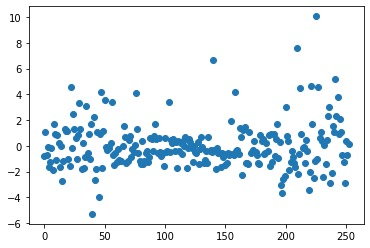

In [340]:
plt.scatter([i for i in range(len(BA1_DTA_1944_n1406_omicron_cases_sample_n_epo_2.resid))],
            BA1_DTA_1944_n1406_omicron_cases_sample_n_epo_2.resid)


In [341]:
with open('./BA.1_DTA_1944_n1406/ltla_residual_epo_2.tsv', 'w+') as outfile:
    outfile.write('ltla\tresidual\n')
    outfile.write('\n'.join(['%s\t%s' % (row.origin, row.resid)
                             for index, row in BA1_DTA_1944_n1406_omicron_cases_sample_n_epo_2.iterrows()]))
    

#### Epoch-3

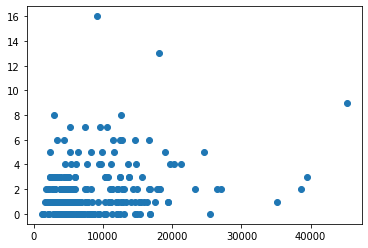

In [342]:
plt.scatter(BA1_DTA_1944_n1406_omicron_cases_sample_n_epo_3.count_mean,
            BA1_DTA_1944_n1406_omicron_cases_sample_n_epo_3.sample_n)
plt.show()


In [343]:
X = sm.add_constant(BA1_DTA_1944_n1406_omicron_cases_sample_n_epo_3.count_mean)
BA1_DTA_1944_n1406_reg_epo_3 = sm.OLS(
    BA1_DTA_1944_n1406_omicron_cases_sample_n_epo_3.sample_n,
    X
).fit()
print(BA1_DTA_1944_n1406_reg_epo_3.summary())
print(BA1_DTA_1944_n1406_reg_epo_3.params)
BA1_DTA_1944_n1406_reg_epo_3.resid


                            OLS Regression Results                            
Dep. Variable:               sample_n   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     14.04
Date:                Mon, 19 Sep 2022   Prob (F-statistic):           0.000222
Time:                        01:46:32   Log-Likelihood:                -541.90
No. Observations:                 253   AIC:                             1088.
Df Residuals:                     251   BIC:                             1095.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2274      0.211      5.818      0.0

0     -0.673487
1     -1.183130
2     -1.623346
3     -0.795195
4     -1.032339
         ...   
248   -1.872506
249   -1.133997
250   -0.047034
251    2.911253
252   -0.697070
Length: 253, dtype: float64

In [344]:
BA1_DTA_1944_n1406_omicron_cases_sample_n_epo_3['resid'] = BA1_DTA_1944_n1406_reg_epo_3.resid
BA1_DTA_1944_n1406_omicron_cases_sample_n_epo_3


,origin,count_mean,sample_n,resid
0,E06000001,6013.218639,1.0,-0.673487
1,E06000004,12883.440526,1.0,-1.183130
2,E06000005,5337.296844,0.0,-1.623346
3,E06000006,7653.898475,1.0,-0.795195
4,E06000007,10850.713185,1.0,-1.032339
...,...,...,...,...
248,E09000029,8696.094999,0.0,-1.872506
249,E09000030,12221.102257,1.0,-1.133997
250,E09000031,11048.812696,2.0,-0.047034
251,E09000032,11611.121439,5.0,2.911253


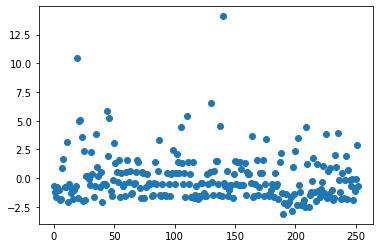

In [345]:
plt.scatter([i for i in range(len(BA1_DTA_1944_n1406_omicron_cases_sample_n_epo_3.resid))],
            BA1_DTA_1944_n1406_omicron_cases_sample_n_epo_3.resid)


In [346]:
with open('./BA.1_DTA_1944_n1406/ltla_residual_epo_3.tsv', 'w+') as outfile:
    outfile.write('ltla\tresidual\n')
    outfile.write('\n'.join(['%s\t%s' % (row.origin, row.resid)
                             for index, row in BA1_DTA_1944_n1406_omicron_cases_sample_n_epo_3.iterrows()]))
    

## Merge LTLAs for BA.1_DTA_1800_n944

In [347]:
BA1_DTA_1800_n944_mergers_rev_dict = dict(zip(BA1_DTA_1800_n944_mergers_rev.child_ltla.values,
                                              BA1_DTA_1800_n944_mergers_rev.parent_ltla.values))

BA1_DTA_1800_n944_omicron_cases_study = omicron_cases.copy()
BA1_DTA_1800_n944_omicron_cases_study.origin = BA1_DTA_1800_n944_omicron_cases_study.origin.apply(
    lambda x: BA1_DTA_1800_n944_mergers_rev_dict[x] if x in BA1_DTA_1800_n944_mergers_rev_dict else x
)
BA1_DTA_1800_n944_omicron_cases_study = BA1_DTA_1800_n944_omicron_cases_study[
    BA1_DTA_1800_n944_omicron_cases_study.origin.isin(BA1_DTA_1800_n944_tip_ltla.ltla.unique().tolist())]

BA1_DTA_1800_n944_omicron_cases_epo_1 = BA1_DTA_1800_n944_omicron_cases_study[
    (BA1_DTA_1800_n944_omicron_cases_study.epoch == 1) &
    (BA1_DTA_1800_n944_omicron_cases_study.date >= dec2date(BA1_DTA_1800_n944_import_est, get_str=True))
].groupby('origin').agg({'count_mean': 'sum'}).reset_index()

BA1_DTA_1800_n944_omicron_cases_epo_2 = BA1_DTA_1800_n944_omicron_cases_study[
    BA1_DTA_1800_n944_omicron_cases_study.epoch == 2
].groupby('origin').agg({'count_mean': 'sum'}).reset_index()

BA1_DTA_1800_n944_omicron_cases_epo_3 = BA1_DTA_1800_n944_omicron_cases_study[
    BA1_DTA_1800_n944_omicron_cases_study.epoch == 3
].groupby('origin').agg({'count_mean': 'sum'}).reset_index()


In [348]:
BA1_DTA_1800_n944_omicron_cases_sample_n_epo_1 = pd.merge(
    BA1_DTA_1800_n944_omicron_cases_epo_1,
    BA1_DTA_1800_n944_tip_ltla[BA1_DTA_1800_n944_tip_ltla.epoch == 1
                              ].groupby('ltla').count().reset_index().rename(columns={'ltla': 'origin'}),
    on='origin', how='left').rename(columns={'name': 'sample_n'})[['origin', 'count_mean', 'sample_n']]
zero_filled_sample_n_epo_1 = BA1_DTA_1800_n944_omicron_cases_sample_n_epo_1.sample_n.apply(
    lambda x: 0 if pd.isna(x) else x)
BA1_DTA_1800_n944_omicron_cases_sample_n_epo_1.sample_n = zero_filled_sample_n_epo_1

BA1_DTA_1800_n944_omicron_cases_sample_n_epo_2 = pd.merge(
    BA1_DTA_1800_n944_omicron_cases_epo_2,
    BA1_DTA_1800_n944_tip_ltla[BA1_DTA_1800_n944_tip_ltla.epoch == 2
                              ].groupby('ltla').count().reset_index().rename(columns={'ltla': 'origin'}),
    on='origin', how='left').rename(columns={'name': 'sample_n'})[['origin', 'count_mean', 'sample_n']]
zero_filled_sample_n_epo_2 = BA1_DTA_1800_n944_omicron_cases_sample_n_epo_2.sample_n.apply(
    lambda x: 0 if pd.isna(x) else x)
BA1_DTA_1800_n944_omicron_cases_sample_n_epo_2.sample_n = zero_filled_sample_n_epo_2

BA1_DTA_1800_n944_omicron_cases_sample_n_epo_3 = pd.merge(
    BA1_DTA_1800_n944_omicron_cases_epo_3,
    BA1_DTA_1800_n944_tip_ltla[BA1_DTA_1800_n944_tip_ltla.epoch == 3
                              ].groupby('ltla').count().reset_index().rename(columns={'ltla': 'origin'}),
    on='origin', how='left').rename(columns={'name': 'sample_n'})[['origin', 'count_mean', 'sample_n']]
zero_filled_sample_n_epo_3 = BA1_DTA_1800_n944_omicron_cases_sample_n_epo_3.sample_n.apply(
    lambda x: 0 if pd.isna(x) else x)
BA1_DTA_1800_n944_omicron_cases_sample_n_epo_3.sample_n = zero_filled_sample_n_epo_3


#### Epoch-1

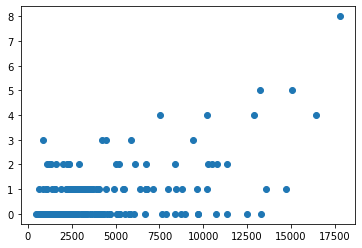

In [357]:
plt.scatter(BA1_DTA_1800_n944_omicron_cases_sample_n_epo_1.count_mean,
            BA1_DTA_1800_n944_omicron_cases_sample_n_epo_1.sample_n)
plt.show()


In [358]:
X = sm.add_constant(BA1_DTA_1800_n944_omicron_cases_sample_n_epo_1.count_mean)
BA1_DTA_1800_n944_reg_epo_1 = sm.OLS(
    BA1_DTA_1800_n944_omicron_cases_sample_n_epo_1.sample_n,
    X
).fit()
print(BA1_DTA_1800_n944_reg_epo_1.summary())
print(BA1_DTA_1800_n944_reg_epo_1.params)
BA1_DTA_1800_n944_reg_epo_1.resid


                            OLS Regression Results                            
Dep. Variable:               sample_n   R-squared:                       0.301
Model:                            OLS   Adj. R-squared:                  0.298
Method:                 Least Squares   F-statistic:                     107.9
Date:                Mon, 19 Sep 2022   Prob (F-statistic):           2.98e-21
Time:                        02:02:58   Log-Likelihood:                -324.10
No. Observations:                 253   AIC:                             652.2
Df Residuals:                     251   BIC:                             659.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0816      0.082     -0.992      0.3

0     -0.057659
1     -0.058587
2      1.720904
3     -0.596790
4     -0.245153
         ...   
248    2.400719
249   -2.146891
250   -1.649074
251    1.162733
252   -0.186140
Length: 253, dtype: float64

In [366]:
BA1_DTA_1800_n944_omicron_cases_sample_n_epo_1['resid'] = BA1_DTA_1800_n944_reg_epo_1.resid
BA1_DTA_1800_n944_omicron_cases_sample_n_epo_1


,origin,count_mean,sample_n,resid
0,E06000002,782.071904,0.0,-0.057659
1,E06000003,787.287536,0.0,-0.058587
2,E06000006,2026.094928,2.0,1.720904
3,E06000007,3810.885166,0.0,-0.596790
4,E06000008,1835.408854,0.0,-0.245153
...,...,...,...,...
248,E09000028,15060.786894,5.0,2.400719
249,E09000030,12519.278694,0.0,-2.146891
250,E09000031,9722.566622,0.0,-1.649074
251,E09000032,16397.776919,4.0,1.162733


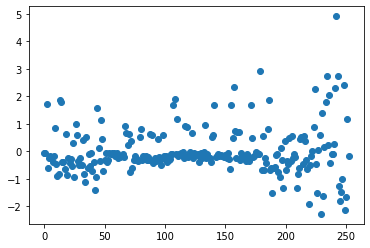

In [360]:
plt.scatter([i for i in range(len(BA1_DTA_1800_n944_omicron_cases_sample_n_epo_1.resid))],
            BA1_DTA_1800_n944_omicron_cases_sample_n_epo_1.resid)


In [361]:
with open('./BA.1_DTA_1800_n944/ltla_residual_epo_1.tsv', 'w+') as outfile:
    outfile.write('ltla\tresidual\n')
    outfile.write('\n'.join(['%s\t%s' % (row.origin, row.resid)
                             for index, row in BA1_DTA_1800_n944_omicron_cases_sample_n_epo_1.iterrows()]))
    

#### Epoch-2

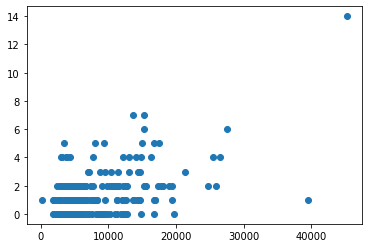

In [372]:
plt.scatter(BA1_DTA_1800_n944_omicron_cases_sample_n_epo_2.count_mean,
            BA1_DTA_1800_n944_omicron_cases_sample_n_epo_2.sample_n)
plt.show()


In [373]:
X = sm.add_constant(BA1_DTA_1800_n944_omicron_cases_sample_n_epo_2.count_mean)
BA1_DTA_1800_n944_reg_epo_2 = sm.OLS(
    BA1_DTA_1800_n944_omicron_cases_sample_n_epo_2.sample_n,
    X
).fit()
print(BA1_DTA_1800_n944_reg_epo_2.summary())
print(BA1_DTA_1800_n944_reg_epo_2.params)
BA1_DTA_1800_n944_reg_epo_2.resid


                            OLS Regression Results                            
Dep. Variable:               sample_n   R-squared:                       0.256
Model:                            OLS   Adj. R-squared:                  0.253
Method:                 Least Squares   F-statistic:                     86.56
Date:                Mon, 19 Sep 2022   Prob (F-statistic):           6.97e-18
Time:                        02:06:15   Log-Likelihood:                -441.41
No. Observations:                 253   AIC:                             886.8
Df Residuals:                     251   BIC:                             893.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2436      0.147      1.660      0.0

0     -1.519922
1     -1.417256
2     -1.282859
3      0.283071
4      1.568273
         ...   
248    1.212830
249    2.096997
250   -1.743827
251    0.179822
252   -0.103251
Length: 253, dtype: float64

In [374]:
BA1_DTA_1800_n944_omicron_cases_sample_n_epo_2['resid'] = BA1_DTA_1800_n944_reg_epo_2.resid
BA1_DTA_1800_n944_omicron_cases_sample_n_epo_2


,origin,count_mean,sample_n,resid
0,E06000002,9399.812953,0.0,-1.519922
1,E06000003,8643.702112,0.0,-1.417256
2,E06000006,7653.898475,0.0,-1.282859
3,E06000007,10850.713185,2.0,0.283071
4,E06000008,8750.272023,3.0,1.568273
...,...,...,...,...
248,E09000028,11368.020617,3.0,1.212830
249,E09000030,12221.102257,4.0,2.096997
250,E09000031,11048.812696,0.0,-1.743827
251,E09000032,11611.121439,2.0,0.179822


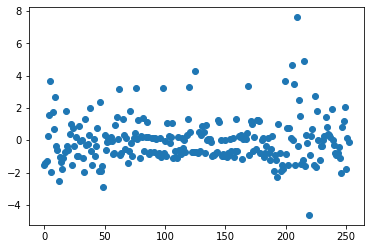

In [375]:
plt.scatter([i for i in range(len(BA1_DTA_1800_n944_omicron_cases_sample_n_epo_2.resid))],
            BA1_DTA_1800_n944_omicron_cases_sample_n_epo_2.resid)


In [376]:
with open('./BA.1_DTA_1800_n944/ltla_residual_epo_2.tsv', 'w+') as outfile:
    outfile.write('ltla\tresidual\n')
    outfile.write('\n'.join(['%s\t%s' % (row.origin, row.resid)
                             for index, row in BA1_DTA_1800_n944_omicron_cases_sample_n_epo_2.iterrows()]))
    

#### Epoch-3

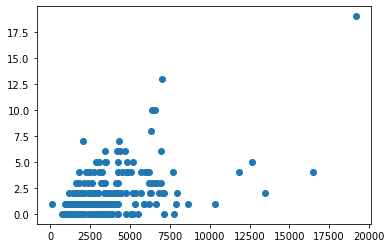

In [377]:
plt.scatter(BA1_DTA_1800_n944_omicron_cases_sample_n_epo_3.count_mean,
            BA1_DTA_1800_n944_omicron_cases_sample_n_epo_3.sample_n)
plt.show()


In [378]:
X = sm.add_constant(BA1_DTA_1800_n944_omicron_cases_sample_n_epo_3.count_mean)
BA1_DTA_1800_n944_reg_epo_3 = sm.OLS(
    BA1_DTA_1800_n944_omicron_cases_sample_n_epo_3.sample_n,
    X
).fit()
print(BA1_DTA_1800_n944_reg_epo_3.summary())
print(BA1_DTA_1800_n944_reg_epo_3.params)
BA1_DTA_1800_n944_reg_epo_3.resid


                            OLS Regression Results                            
Dep. Variable:               sample_n   R-squared:                       0.255
Model:                            OLS   Adj. R-squared:                  0.252
Method:                 Least Squares   F-statistic:                     85.79
Date:                Mon, 19 Sep 2022   Prob (F-statistic):           9.32e-18
Time:                        02:06:46   Log-Likelihood:                -515.99
No. Observations:                 253   AIC:                             1036.
Df Residuals:                     251   BIC:                             1043.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2413      0.209      1.157      0.2

0     -0.542255
1     -0.414345
2     -0.355339
3      0.207342
4     -0.506011
         ...   
248   -0.072464
249   -0.222945
250   -1.085715
251   -0.702704
252    0.503959
Length: 253, dtype: float64

In [379]:
BA1_DTA_1800_n944_omicron_cases_sample_n_epo_3['resid'] = BA1_DTA_1800_n944_reg_epo_3.resid
BA1_DTA_1800_n944_omicron_cases_sample_n_epo_3


,origin,count_mean,sample_n,resid
0,E06000002,2843.019016,1.0,-0.542255
1,E06000003,2563.482609,1.0,-0.414345
2,E06000006,2434.531879,1.0,-0.355339
3,E06000007,3390.253717,2.0,0.207342
4,E06000008,2763.811373,1.0,-0.506011
...,...,...,...,...
248,E09000028,4001.745160,2.0,-0.072464
249,E09000030,4330.607922,2.0,-0.222945
250,E09000031,4030.702329,1.0,-1.085715
251,E09000032,5379.078310,2.0,-0.702704


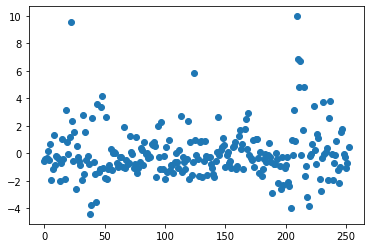

In [380]:
plt.scatter([i for i in range(len(BA1_DTA_1800_n944_omicron_cases_sample_n_epo_3.resid))],
            BA1_DTA_1800_n944_omicron_cases_sample_n_epo_3.resid)


In [381]:
with open('./BA.1_DTA_1800_n944/ltla_residual_epo_3.tsv', 'w+') as outfile:
    outfile.write('ltla\tresidual\n')
    outfile.write('\n'.join(['%s\t%s' % (row.origin, row.resid)
                             for index, row in BA1_DTA_1800_n944_omicron_cases_sample_n_epo_3.iterrows()]))
    

## Merge LTLAs for BA.1_DTA_1207_n9727

In [382]:
BA1_DTA_1207_n9727_mergers_rev_dict = dict(zip(BA1_DTA_1207_n9727_mergers_rev.child_ltla.values,
                                               BA1_DTA_1207_n9727_mergers_rev.parent_ltla.values))

BA1_DTA_1207_n9727_omicron_cases_study = omicron_cases.copy()
BA1_DTA_1207_n9727_omicron_cases_study.origin = BA1_DTA_1207_n9727_omicron_cases_study.origin.apply(
    lambda x: BA1_DTA_1207_n9727_mergers_rev_dict[x] if x in BA1_DTA_1207_n9727_mergers_rev_dict else x
)
BA1_DTA_1207_n9727_omicron_cases_study = BA1_DTA_1207_n9727_omicron_cases_study[
    BA1_DTA_1207_n9727_omicron_cases_study.origin.isin(BA1_DTA_1207_n9727_tip_ltla.ltla.unique().tolist())]

BA1_DTA_1207_n9727_omicron_cases_epo_1 = BA1_DTA_1207_n9727_omicron_cases_study[
    (BA1_DTA_1207_n9727_omicron_cases_study.epoch == 1) &
    (BA1_DTA_1207_n9727_omicron_cases_study.date >= dec2date(BA1_DTA_1207_n9727_import_est, get_str=True))
].groupby('origin').agg({'count_mean': 'sum'}).reset_index()

BA1_DTA_1207_n9727_omicron_cases_epo_2 = BA1_DTA_1207_n9727_omicron_cases_study[
    BA1_DTA_1207_n9727_omicron_cases_study.epoch == 2
].groupby('origin').agg({'count_mean': 'sum'}).reset_index()

BA1_DTA_1207_n9727_omicron_cases_epo_3 = BA1_DTA_1207_n9727_omicron_cases_study[
    BA1_DTA_1207_n9727_omicron_cases_study.epoch == 3
].groupby('origin').agg({'count_mean': 'sum'}).reset_index()


In [383]:
BA1_DTA_1207_n9727_omicron_cases_sample_n_epo_1 = pd.merge(
    BA1_DTA_1207_n9727_omicron_cases_epo_1,
    BA1_DTA_1207_n9727_tip_ltla[BA1_DTA_1207_n9727_tip_ltla.epoch == 1
                               ].groupby('ltla').count().reset_index().rename(columns={'ltla': 'origin'}),
    on='origin', how='left').rename(columns={'name': 'sample_n'})[['origin', 'count_mean', 'sample_n']]
zero_filled_sample_n_epo_1 = BA1_DTA_1207_n9727_omicron_cases_sample_n_epo_1.sample_n.apply(
    lambda x: 0 if pd.isna(x) else x)
BA1_DTA_1207_n9727_omicron_cases_sample_n_epo_1.sample_n = zero_filled_sample_n_epo_1

BA1_DTA_1207_n9727_omicron_cases_sample_n_epo_2 = pd.merge(
    BA1_DTA_1207_n9727_omicron_cases_epo_2,
    BA1_DTA_1207_n9727_tip_ltla[BA1_DTA_1207_n9727_tip_ltla.epoch == 2
                               ].groupby('ltla').count().reset_index().rename(columns={'ltla': 'origin'}),
    on='origin', how='left').rename(columns={'name': 'sample_n'})[['origin', 'count_mean', 'sample_n']]
zero_filled_sample_n_epo_2 = BA1_DTA_1207_n9727_omicron_cases_sample_n_epo_2.sample_n.apply(
    lambda x: 0 if pd.isna(x) else x)
BA1_DTA_1207_n9727_omicron_cases_sample_n_epo_2.sample_n = zero_filled_sample_n_epo_2

BA1_DTA_1207_n9727_omicron_cases_sample_n_epo_3 = pd.merge(
    BA1_DTA_1207_n9727_omicron_cases_epo_2,
    BA1_DTA_1207_n9727_tip_ltla[BA1_DTA_1207_n9727_tip_ltla.epoch == 3
                               ].groupby('ltla').count().reset_index().rename(columns={'ltla': 'origin'}),
    on='origin', how='left').rename(columns={'name': 'sample_n'})[['origin', 'count_mean', 'sample_n']]
zero_filled_sample_n_epo_3 = BA1_DTA_1207_n9727_omicron_cases_sample_n_epo_3.sample_n.apply(
    lambda x: 0 if pd.isna(x) else x)
BA1_DTA_1207_n9727_omicron_cases_sample_n_epo_3.sample_n = zero_filled_sample_n_epo_3


#### Epoch-1

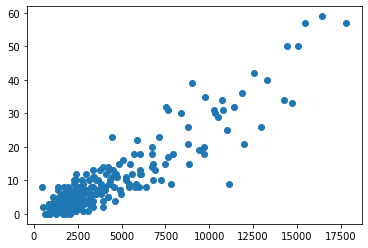

In [391]:
plt.scatter(BA1_DTA_1207_n9727_omicron_cases_sample_n_epo_1.count_mean,
            BA1_DTA_1207_n9727_omicron_cases_sample_n_epo_1.sample_n)
plt.show()


In [392]:
X = sm.add_constant(BA1_DTA_1207_n9727_omicron_cases_sample_n_epo_1.count_mean)
BA1_DTA_1207_n9727_reg_epo_1 = sm.OLS(
    BA1_DTA_1207_n9727_omicron_cases_sample_n_epo_1.sample_n,
    X
).fit()
print(BA1_DTA_1207_n9727_reg_epo_1.summary())
print(BA1_DTA_1207_n9727_reg_epo_1.params)
BA1_DTA_1207_n9727_reg_epo_1.resid


                            OLS Regression Results                            
Dep. Variable:               sample_n   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     1230.
Date:                Mon, 19 Sep 2022   Prob (F-statistic):           9.88e-99
Time:                        02:12:17   Log-Likelihood:                -730.63
No. Observations:                 253   AIC:                             1465.
Df Residuals:                     251   BIC:                             1472.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.9983      0.428     -4.666      0.0

0      -3.351791
1      -3.873909
2      -1.026899
3      -7.292598
4       0.749034
         ...    
248    -4.995398
249     7.754931
250     8.854456
251    13.545890
252     4.378098
Length: 253, dtype: float64

In [393]:
BA1_DTA_1207_n9727_omicron_cases_sample_n_epo_1['resid'] = BA1_DTA_1207_n9727_reg_epo_1.resid
BA1_DTA_1207_n9727_omicron_cases_sample_n_epo_1


,origin,count_mean,sample_n,resid
0,E06000004,3236.310907,4.0,-3.351791
1,E06000006,2032.529455,0.0,-3.873909
2,E06000007,3816.107467,8.0,-1.026899
3,E06000008,5984.821921,8.0,-7.292598
4,E06000009,1470.788539,3.0,0.749034
...,...,...,...,...
248,E09000029,6920.328151,13.0,-4.995398
249,E09000030,12544.743456,42.0,7.754931
250,E09000031,9741.296396,35.0,8.854456
251,E09000032,16424.471480,59.0,13.545890


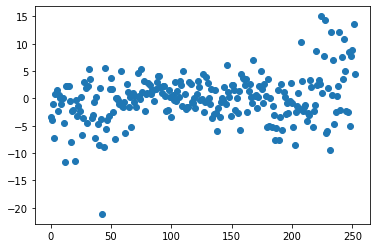

In [394]:
plt.scatter([i for i in range(len(BA1_DTA_1207_n9727_omicron_cases_sample_n_epo_1.resid))],
            BA1_DTA_1207_n9727_omicron_cases_sample_n_epo_1.resid)


In [395]:
with open('./BA.1_DTA_1207_n9727/ltla_residual_epo_1.tsv', 'w+') as outfile:
    outfile.write('ltla\tresidual\n')
    outfile.write('\n'.join(['%s\t%s' % (row.origin, row.resid)
                             for index, row in BA1_DTA_1207_n9727_omicron_cases_sample_n_epo_1.iterrows()]))
    

#### Epoch-2

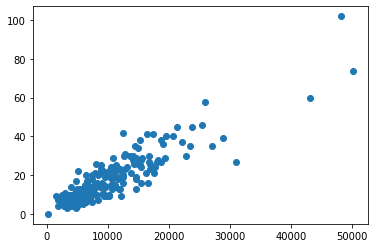

In [396]:
plt.scatter(BA1_DTA_1207_n9727_omicron_cases_sample_n_epo_2.count_mean,
            BA1_DTA_1207_n9727_omicron_cases_sample_n_epo_2.sample_n)
plt.show()


In [397]:
X = sm.add_constant(BA1_DTA_1207_n9727_omicron_cases_sample_n_epo_2.count_mean)
BA1_DTA_1207_n9727_reg_epo_2 = sm.OLS(
    BA1_DTA_1207_n9727_omicron_cases_sample_n_epo_2.sample_n,
    X
).fit()
print(BA1_DTA_1207_n9727_reg_epo_2.summary())
print(BA1_DTA_1207_n9727_reg_epo_2.params)
BA1_DTA_1207_n9727_reg_epo_2.resid


                            OLS Regression Results                            
Dep. Variable:               sample_n   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     1131.
Date:                Mon, 19 Sep 2022   Prob (F-statistic):           5.85e-95
Time:                        02:13:35   Log-Likelihood:                -779.08
No. Observations:                 253   AIC:                             1562.
Df Residuals:                     251   BIC:                             1569.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2820      0.545      2.352      0.0

0     -23.857808
1       1.448852
2      10.324365
3       5.686148
4      -4.241064
         ...    
248    -1.221787
249    -1.872366
250     4.006812
251    -1.894568
252     0.569241
Length: 253, dtype: float64

In [398]:
BA1_DTA_1207_n9727_omicron_cases_sample_n_epo_2['resid'] = BA1_DTA_1207_n9727_reg_epo_2.resid
BA1_DTA_1207_n9727_omicron_cases_sample_n_epo_2


,origin,count_mean,sample_n,resid
0,E06000004,30926.955590,27.0,-23.857808
1,E06000006,7653.898475,15.0,1.448852
2,E06000007,10850.713185,29.0,10.324365
3,E06000008,23725.476234,45.0,5.686148
4,E06000009,8084.289389,10.0,-4.241064
...,...,...,...,...
248,E09000029,8696.094999,14.0,-1.221787
249,E09000030,12221.102257,19.0,-1.872366
250,E09000031,11048.812696,23.0,4.006812
251,E09000032,11611.121439,18.0,-1.894568


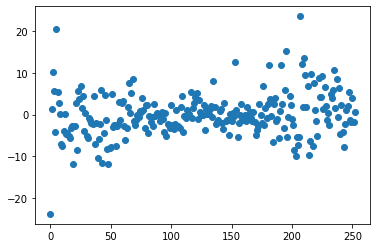

In [399]:
plt.scatter([i for i in range(len(BA1_DTA_1207_n9727_omicron_cases_sample_n_epo_2.resid))],
            BA1_DTA_1207_n9727_omicron_cases_sample_n_epo_2.resid)


In [400]:
with open('./BA.1_DTA_1207_n9727/ltla_residual_epo_2.tsv', 'w+') as outfile:
    outfile.write('ltla\tresidual\n')
    outfile.write('\n'.join(['%s\t%s' % (row.origin, row.resid)
                             for index, row in BA1_DTA_1207_n9727_omicron_cases_sample_n_epo_2.iterrows()]))
    

#### Epoch-3

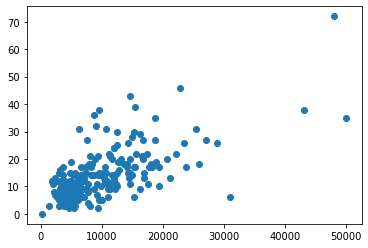

In [401]:
plt.scatter(BA1_DTA_1207_n9727_omicron_cases_sample_n_epo_3.count_mean,
            BA1_DTA_1207_n9727_omicron_cases_sample_n_epo_3.sample_n)
plt.show()


In [402]:
X = sm.add_constant(BA1_DTA_1207_n9727_omicron_cases_sample_n_epo_3.count_mean)
BA1_DTA_1207_n9727_reg_epo_3 = sm.OLS(
    BA1_DTA_1207_n9727_omicron_cases_sample_n_epo_3.sample_n,
    X
).fit()
print(BA1_DTA_1207_n9727_reg_epo_3.summary())
print(BA1_DTA_1207_n9727_reg_epo_3.params)
BA1_DTA_1207_n9727_reg_epo_3.resid


                            OLS Regression Results                            
Dep. Variable:               sample_n   R-squared:                       0.453
Model:                            OLS   Adj. R-squared:                  0.451
Method:                 Least Squares   F-statistic:                     208.3
Date:                Mon, 19 Sep 2022   Prob (F-statistic):           8.69e-35
Time:                        02:14:25   Log-Likelihood:                -834.05
No. Observations:                 253   AIC:                             1672.
Df Residuals:                     251   BIC:                             1679.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.3395      0.677      7.883      0.0

0     -25.775681
1      -2.882021
2      -3.614637
3      -8.619902
4      -9.249916
         ...    
248    -3.772884
249    -6.786037
250    -5.783972
251     4.735371
252     1.248670
Length: 253, dtype: float64

In [403]:
BA1_DTA_1207_n9727_omicron_cases_sample_n_epo_3['resid'] = BA1_DTA_1207_n9727_reg_epo_3.resid
BA1_DTA_1207_n9727_omicron_cases_sample_n_epo_3


,origin,count_mean,sample_n,resid
0,E06000004,30926.955590,6.0,-25.775681
1,E06000006,7653.898475,9.0,-2.882021
2,E06000007,10850.713185,11.0,-3.614637
3,E06000008,23725.476234,17.0,-8.619902
4,E06000009,8084.289389,3.0,-9.249916
...,...,...,...,...
248,E09000029,8696.094999,9.0,-3.772884
249,E09000030,12221.102257,9.0,-6.786037
250,E09000031,11048.812696,9.0,-5.783972
251,E09000032,11611.121439,20.0,4.735371


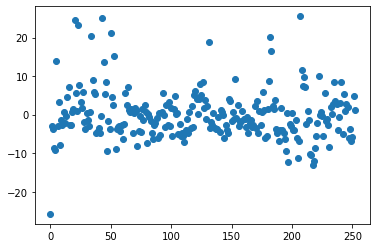

In [404]:
plt.scatter([i for i in range(len(BA1_DTA_1207_n9727_omicron_cases_sample_n_epo_3.resid))],
            BA1_DTA_1207_n9727_omicron_cases_sample_n_epo_3.resid)


In [405]:
with open('./BA.1_DTA_1207_n9727/ltla_residual_epo_3.tsv', 'w+') as outfile:
    outfile.write('ltla\tresidual\n')
    outfile.write('\n'.join(['%s\t%s' % (row.origin, row.resid)
                             for index, row in BA1_DTA_1207_n9727_omicron_cases_sample_n_epo_3.iterrows()]))
    